In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
from scipy.stats import zscore

# 데이터 다운로드 (2019년부터)
btc = yf.download('BTC-USD', start='2019-01-01', end='2024-01-01')

# RSI 계산 함수
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# MACD 계산 함수
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# 볼린저 밴드 계산 함수
def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# 전략 함수들 정의
# 1. 이동평균선 전략
def moving_average_strategy(start, end, short_window=20, long_window=60):
    cash = 10000
    btc_owned = 0
    invested = False
    
    # 이동평균선 계산
    btc['MA20'] = btc['Close'].rolling(window=short_window).mean()
    btc['MA60'] = btc['Close'].rolling(window=long_window).mean()
    
    for i in range(start + long_window, end):
        if btc['MA20'].iloc[i] > btc['MA60'].iloc[i] and not invested:  # 골든 크로스 매수
            btc_owned = cash / btc['Close'].iloc[i]
            cash = 0
            invested = True
        elif btc['MA20'].iloc[i] < btc['MA60'].iloc[i] and invested:  # 데드 크로스 매도
            cash = btc_owned * btc['Close'].iloc[i]
            btc_owned = 0
            invested = False
    
    final_value = cash + btc_owned * btc['Close'].iloc[end]
    return final_value

# 2. RSI 전략
def rsi_strategy(start, end):
    cash = 10000
    btc_owned = 0
    invested = False
    btc['RSI'] = calculate_rsi(btc)
    
    for i in range(start, end):
        if btc['RSI'].iloc[i] < 30 and not invested:  # 매수
            btc_owned = cash / btc['Close'].iloc[i]
            cash = 0
            invested = True
        elif btc['RSI'].iloc[i] > 70 and invested:  # 매도
            cash = btc_owned * btc['Close'].iloc[i]
            btc_owned = 0
            invested = False
    
    final_value = cash + btc_owned * btc['Close'].iloc[end]
    return final_value

# 3. 추세선 전략
def trendline_strategy(start, end):
    cash = 10000
    btc_owned = 0
    invested = False
    
    for i in range(start + 20, end):  # 20일 이후부터 시작
        trendline = np.polyfit(range(i+1), btc['Close'][:i+1], 1)
        trendline_value = np.polyval(trendline, i)
        if btc['Close'].iloc[i] < trendline_value and not invested:  # 매수
            btc_owned = cash / btc['Close'].iloc[i]
            cash = 0
            invested = True
        elif btc['Close'].iloc[i] > trendline_value and invested:  # 매도
            cash = btc_owned * btc['Close'].iloc[i]
            btc_owned = 0
            invested = False
    
    final_value = cash + btc_owned * btc['Close'].iloc[end]
    return final_value

# 4. MACD 전략
def macd_strategy(start, end):
    cash = 10000
    btc_owned = 0
    invested = False
    btc['MACD'], btc['Signal'] = calculate_macd(btc)
    
    for i in range(start, end):
        if btc['MACD'].iloc[i] > btc['Signal'].iloc[i] and not invested:  # MACD가 신호선을 상향 돌파할 때 매수
            btc_owned = cash / btc['Close'].iloc[i]
            cash = 0
            invested = True
        elif btc['MACD'].iloc[i] < btc['Signal'].iloc[i] and invested:  # MACD가 신호선을 하향 돌파할 때 매도
            cash = btc_owned * btc['Close'].iloc[i]
            btc_owned = 0
            invested = False
    
    final_value = cash + btc_owned * btc['Close'].iloc[end]
    return final_value

# 5. Bollinger Bands 전략
def bollinger_strategy(start, end):
    cash = 10000
    btc_owned = 0
    invested = False
    btc['Upper Band'], btc['Lower Band'] = calculate_bollinger_bands(btc)
    
    for i in range(start, end):
        if btc['Close'].iloc[i] < btc['Lower Band'].iloc[i] and not invested:  # 가격이 하단 밴드 아래에 있을 때 매수
            btc_owned = cash / btc['Close'].iloc[i]
            cash = 0
            invested = True
        elif btc['Close'].iloc[i] > btc['Upper Band'].iloc[i] and invested:  # 가격이 상단 밴드 위에 있을 때 매도
            cash = btc_owned * btc['Close'].iloc[i]
            btc_owned = 0
            invested = False
    
    final_value = cash + btc_owned * btc['Close'].iloc[end]
    return final_value

# 6. Buy and Hold 전략 (비교용)
def buy_and_hold(start, end):
    initial_price = btc['Close'].iloc[start]
    final_price = btc['Close'].iloc[end]
    return (final_price / initial_price) * 10000  # 투자 초기 자산을 $10,000로 가정

# 7. 2배 레버리지 전략
def leveraged_strategy(btc, start, end, leverage=2):
    cash = 10000
    btc_owned = cash / btc['Close'].iloc[start]
    cash = 0
    
    for i in range(start + 1, end + 1):
        daily_return = (btc['Close'].iloc[i] / btc['Close'].iloc[i-1]) - 1
        leveraged_return = leverage * daily_return
        btc_owned *= (1 + leveraged_return)
    
    final_value = btc_owned * btc['Close'].iloc[end]
    return final_value

# 시뮬레이션 실행 함수 정의
def run_simulation(index):
    start = random.randint(60, len(btc) - 365)
    max_possible_end = len(btc) - 1
    end = random.randint(start + 5, min(start + 365, max_possible_end))  # 최소 5일에서 최대 1년 이내의 랜덤 시점
    
    start_date = btc.index[start]
    end_date = btc.index[end]
    start_price = btc['Close'].iloc[start]
    end_price = btc['Close'].iloc[end]
    
    investment_period = end_date - start_date
    years = investment_period.days // 365
    months = (investment_period.days % 365) // 30
    
    result = {
        'Start Date': start_date,
        'End Date': end_date,
        'Start BTC Price': start_price,
        'End BTC Price': end_price,
        'Investment Period (years)': years,
        'Investment Period (months)': months,
        'Buy and Hold': buy_and_hold(start, end),
        'Trendline': trendline_strategy(start, end),
        'RSI': rsi_strategy(start, end),
        'Moving Average': moving_average_strategy(start, end),
        'MACD': macd_strategy(start, end),
        'Bollinger Bands': bollinger_strategy(start, end),
        '2x Leverage': leveraged_strategy(btc, start, end, leverage=2)
    }
    
    return result


[*********************100%%**********************]  1 of 1 completed


                          Start Date                       End Date  \
count                          49001                          49001   
mean   2021-02-05 23:03:43.415848960  2021-08-06 18:49:50.877737216   
min              2019-03-02 00:00:00            2019-03-11 00:00:00   
25%              2020-02-09 00:00:00            2020-08-14 00:00:00   
50%              2021-02-15 00:00:00            2021-08-17 00:00:00   
75%              2022-01-25 00:00:00            2022-07-27 00:00:00   
max              2023-01-01 00:00:00            2023-12-31 00:00:00   
std                              NaN                            NaN   

       Start BTC Price  End BTC Price  Investment Period (years)  \
count     49001.000000   49001.000000               49001.000000   
mean      24671.559372   26285.707571                   0.002796   
min        3761.557129    3905.227295                   0.000000   
25%        9477.677734   10796.951172                   0.000000   
50%       19154.2304

C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\2865026897.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_df['Buy and Hold'], results_df['Trendline'], results_df['RSI'], results_df['Moving Average'], results_df['MACD'], results_df['Bollinger Bands'], results_df['2x Leverage']],


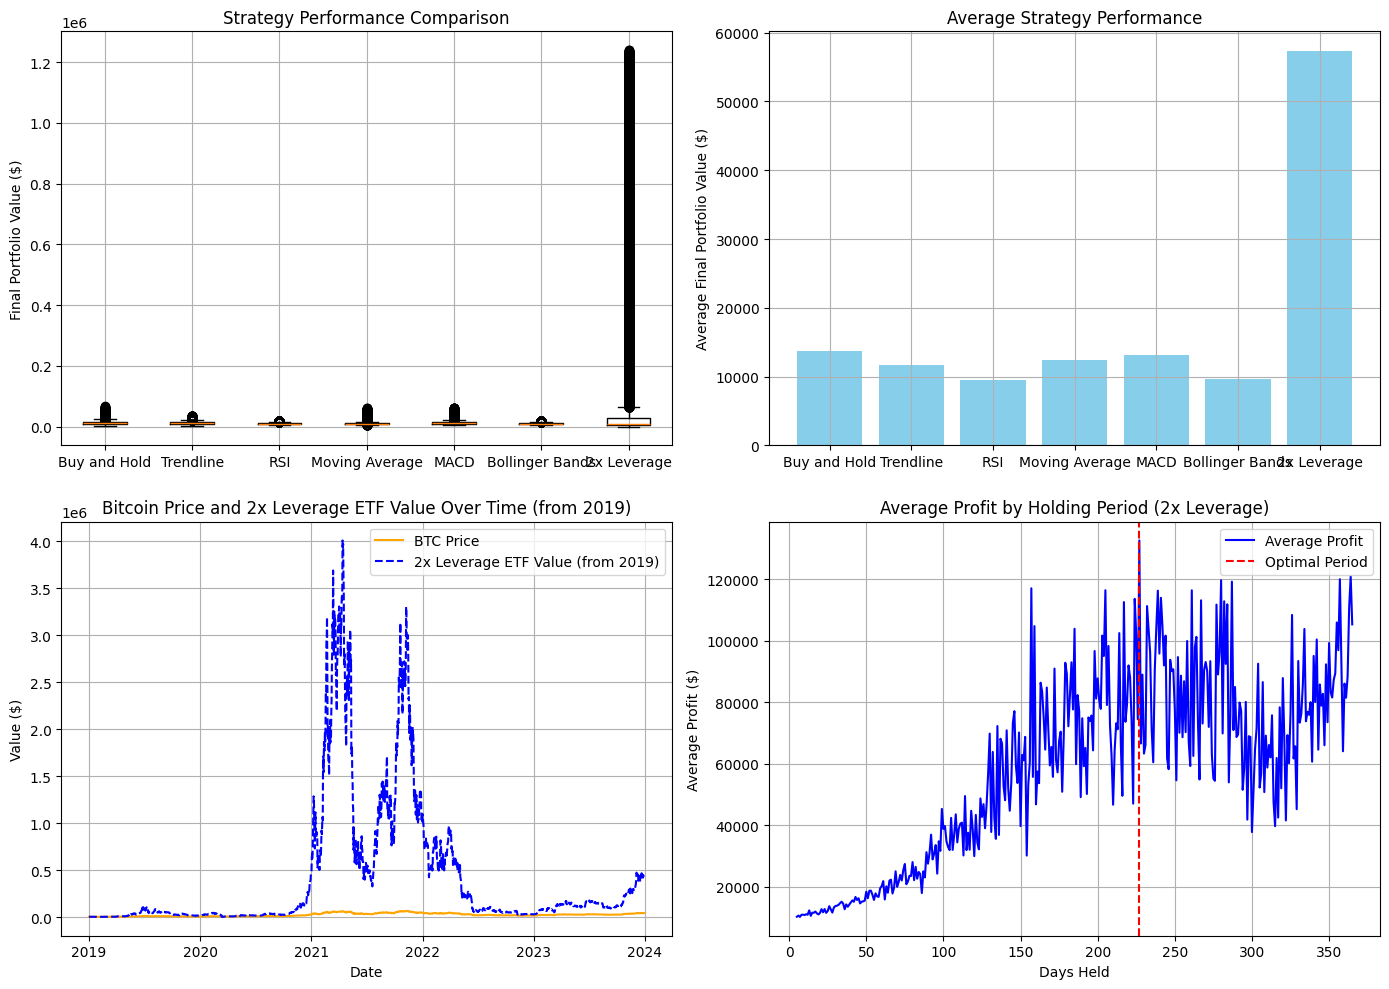

In [5]:

# 5000번 시뮬레이션 병렬 실행
num_simulations = 50000
results = Parallel(n_jobs=-1)(delayed(run_simulation)(i) for i in range(num_simulations))

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 하락장 필터링
bear_market_df = results_df[results_df['End BTC Price'] < results_df['Start BTC Price']]

# 이상치 제거 (z-score를 사용하여 필터링)
results_df = results_df[(np.abs(zscore(results_df['2x Leverage'])) < 3)]

# 승률 계산
win_rates = {
    'Buy and Hold': (results_df['Buy and Hold'] > 10000).mean(),
    'Trendline': (results_df['Trendline'] > 10000).mean(),
    'RSI': (results_df['RSI'] > 10000).mean(),
    'Moving Average': (results_df['Moving Average'] > 10000).mean(),
    'MACD': (results_df['MACD'] > 10000).mean(),
    'Bollinger Bands': (results_df['Bollinger Bands'] > 10000).mean(),
    '2x Leverage': (results_df['2x Leverage'] > 10000).mean()
}

bear_market_win_rates = {
    'Buy and Hold': (bear_market_df['Buy and Hold'] > 10000).mean(),
    'Trendline': (bear_market_df['Trendline'] > 10000).mean(),
    'RSI': (bear_market_df['RSI'] > 10000).mean(),
    'Moving Average': (bear_market_df['Moving Average'] > 10000).mean(),
    'MACD': (bear_market_df['MACD'] > 10000).mean(),
    'Bollinger Bands': (bear_market_df['Bollinger Bands'] > 10000).mean(),
    '2x Leverage': (bear_market_df['2x Leverage'] > 10000).mean()
}

# 결과 출력
print(results_df.describe())
print("Overall Win Rates for Each Strategy:")
print(win_rates)
print("Bear Market Win Rates for Each Strategy:")
print(bear_market_win_rates)

# 시각화 - 성과 비교 및 최적의 투자 기간
plt.figure(figsize=(14, 10))

# 상자 그림
plt.subplot(2, 2, 1)
plt.boxplot([results_df['Buy and Hold'], results_df['Trendline'], results_df['RSI'], results_df['Moving Average'], results_df['MACD'], results_df['Bollinger Bands'], results_df['2x Leverage']], 
            labels=['Buy and Hold', 'Trendline', 'RSI', 'Moving Average', 'MACD', 'Bollinger Bands', '2x Leverage'])
plt.title('Strategy Performance Comparison')
plt.ylabel('Final Portfolio Value ($)')
plt.grid(True)

# 막대 그래프 - 평균 수익 비교
plt.subplot(2, 2, 2)
means = [results_df['Buy and Hold'].mean(), results_df['Trendline'].mean(), results_df['RSI'].mean(), results_df['Moving Average'].mean(), results_df['MACD'].mean(), results_df['Bollinger Bands'].mean(), results_df['2x Leverage'].mean()]
plt.bar(['Buy and Hold', 'Trendline', 'RSI', 'Moving Average', 'MACD', 'Bollinger Bands', '2x Leverage'], means, color='skyblue')
plt.title('Average Strategy Performance')
plt.ylabel('Average Final Portfolio Value ($)')
plt.grid(True)

# 비트코인 가격 및 2배 레버리지 ETF 그래프 (2019년 이후)
btc_2019 = btc.loc['2019-01-01':]
initial_value = btc_2019['Close'].iloc[0]
leveraged_etf_values = [leveraged_strategy(btc_2019, 0, i, leverage=2) for i in range(len(btc_2019))]
leveraged_etf_values = [value * (initial_value / leveraged_etf_values[0]) for value in leveraged_etf_values]  # 비트코인 시작 값에 맞춰 조정

plt.subplot(2, 2, 3)
plt.plot(btc_2019['Close'], label='BTC Price', color='orange')
plt.plot(btc_2019.index, leveraged_etf_values, label='2x Leverage ETF Value (from 2019)', color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.title('Bitcoin Price and 2x Leverage ETF Value Over Time (from 2019)')
plt.legend()
plt.grid(True)

# 최적의 투자 기간 시각화
days_held = results_df['End Date'] - results_df['Start Date']
days_held = days_held.dt.days
avg_profit_by_days = results_df['2x Leverage'].groupby(days_held).mean()

plt.subplot(2, 2, 4)
plt.plot(avg_profit_by_days.index, avg_profit_by_days.values, label='Average Profit', color='blue')
plt.axvline(avg_profit_by_days.idxmax(), color='red', linestyle='--', label='Optimal Period')
plt.xlabel('Days Held')
plt.ylabel('Average Profit ($)')
plt.title('Average Profit by Holding Period (2x Leverage)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


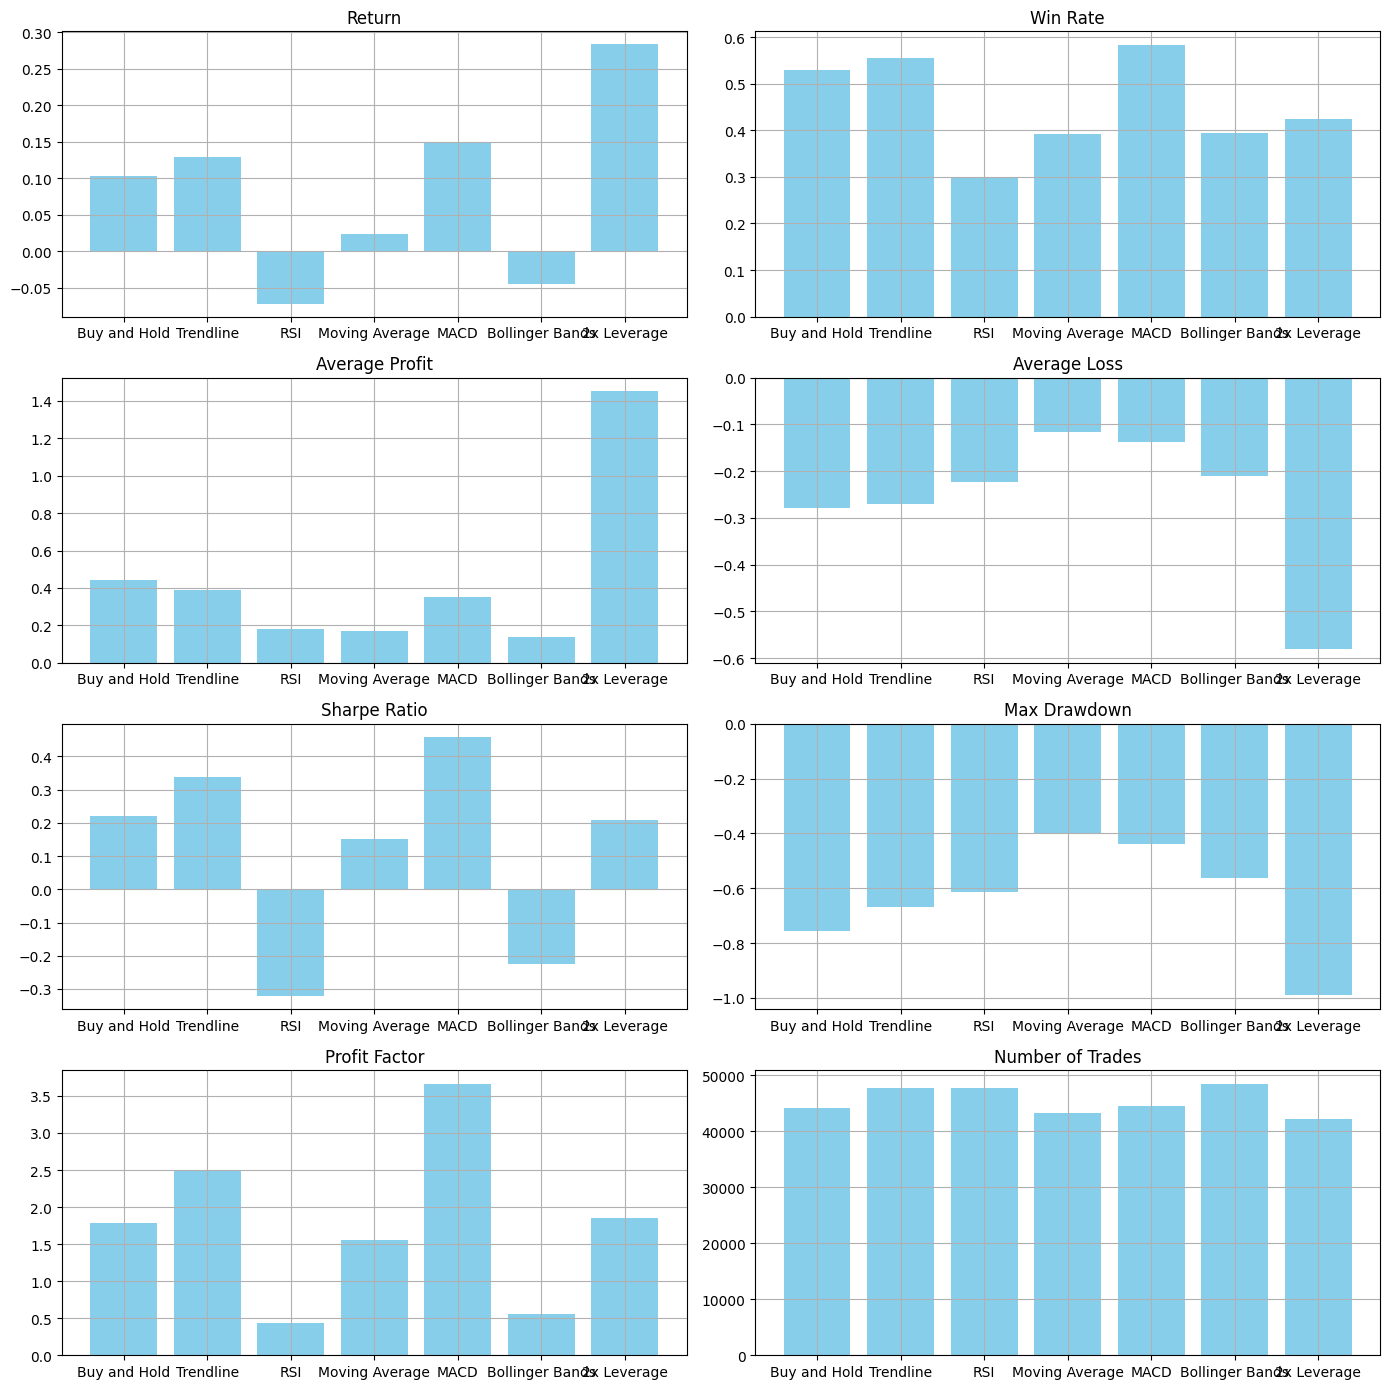

C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\754864621.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([filtered_data['Buy and Hold'], filtered_data['Trendline'], filtered_data['RSI'], filtered_data['Moving Average'],


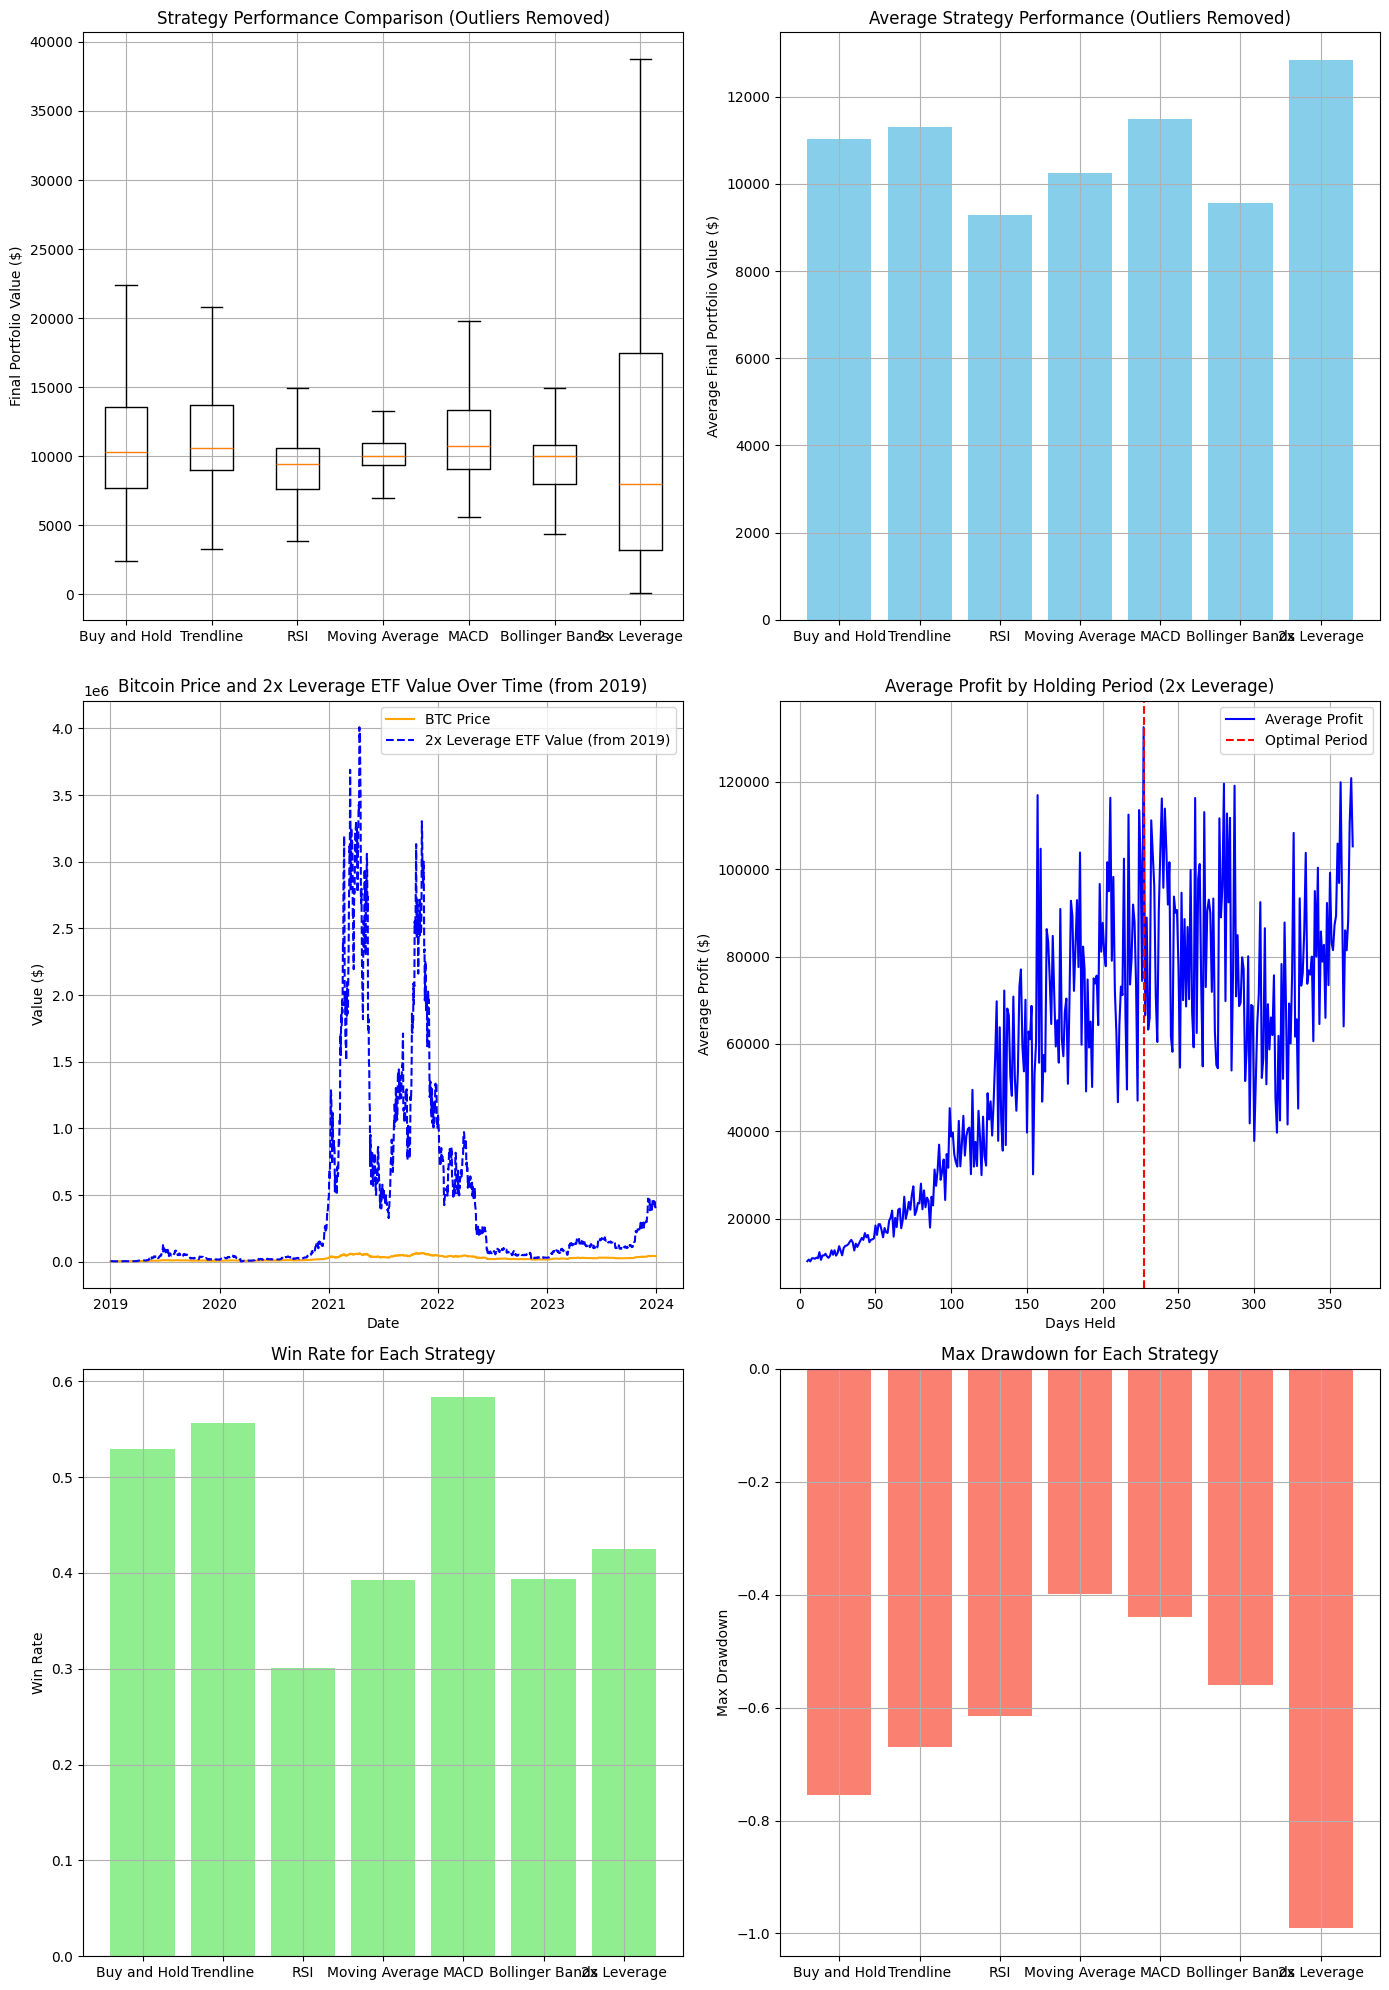

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import zscore

# 이상치 제거 함수 (강화된 버전)
def remove_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data >= lower_bound) & (data <= upper_bound)]

# 각 전략의 데이터에서 이상치 제거
filtered_data = {
    'Buy and Hold': remove_outliers(results_df['Buy and Hold']),
    'Trendline': remove_outliers(results_df['Trendline']),
    'RSI': remove_outliers(results_df['RSI']),
    'Moving Average': remove_outliers(results_df['Moving Average']),
    'MACD': remove_outliers(results_df['MACD']),
    'Bollinger Bands': remove_outliers(results_df['Bollinger Bands']),
    '2x Leverage': remove_outliers(results_df['2x Leverage'])
}

# 주요 지표 계산 함수
def calculate_metrics(strategy_returns):
    returns = strategy_returns / 10000 - 1
    win_rate = (strategy_returns > 10000).mean()
    avg_profit = returns[returns > 0].mean()
    avg_loss = returns[returns < 0].mean()
    sharpe_ratio = returns.mean() / returns.std() if returns.std() != 0 else 0
    max_drawdown = returns.min()
    profit_factor = returns[returns > 0].sum() / -returns[returns < 0].sum() if -returns[returns < 0].sum() != 0 else np.nan
    num_trades = len(returns)
    
    return {
        'Return': returns.mean(),
        'Win Rate': win_rate,
        'Average Profit': avg_profit,
        'Average Loss': avg_loss,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Profit Factor': profit_factor,
        'Number of Trades': num_trades
    }

# 각 전략별로 주요 지표 계산
metrics = {strategy: calculate_metrics(filtered_data[strategy]) for strategy in filtered_data}

# 결과를 DataFrame으로 변환
metrics_df = pd.DataFrame(metrics).T

# 지표별 시각화
plt.figure(figsize=(14, 14))

# 각 지표에 대해 개별 그래프 생성
for i, metric in enumerate(metrics_df.columns):
    plt.subplot(4, 2, i + 1)
    plt.bar(metrics_df.index, metrics_df[metric], color='skyblue')
    plt.title(metric)
    plt.grid(True)

plt.tight_layout()
plt.show()

# 기존의 시각화와 함께 주요 지표 추가
plt.figure(figsize=(14, 20))

# 상자 그림 (이상치 제거 후)
plt.subplot(3, 2, 1)
plt.boxplot([filtered_data['Buy and Hold'], filtered_data['Trendline'], filtered_data['RSI'], filtered_data['Moving Average'], 
             filtered_data['MACD'], filtered_data['Bollinger Bands'], filtered_data['2x Leverage']], 
            labels=['Buy and Hold', 'Trendline', 'RSI', 'Moving Average', 'MACD', 'Bollinger Bands', '2x Leverage'],
            showfliers=False)  # 이상치 표시 제거
plt.title('Strategy Performance Comparison (Outliers Removed)')
plt.ylabel('Final Portfolio Value ($)')
plt.grid(True)

# 막대 그래프 - 평균 수익 비교
plt.subplot(3, 2, 2)
means = [filtered_data['Buy and Hold'].mean(), filtered_data['Trendline'].mean(), filtered_data['RSI'].mean(), 
         filtered_data['Moving Average'].mean(), filtered_data['MACD'].mean(), filtered_data['Bollinger Bands'].mean(), 
         filtered_data['2x Leverage'].mean()]
plt.bar(['Buy and Hold', 'Trendline', 'RSI', 'Moving Average', 'MACD', 'Bollinger Bands', '2x Leverage'], means, color='skyblue')
plt.title('Average Strategy Performance (Outliers Removed)')
plt.ylabel('Average Final Portfolio Value ($)')
plt.grid(True)

# 비트코인 가격 및 2배 레버리지 ETF 그래프 (2019년 이후)
btc_2019 = btc.loc['2019-01-01':]
initial_value = btc_2019['Close'].iloc[0]
leveraged_etf_values = [leveraged_strategy(btc_2019, 0, i, leverage=2) for i in range(len(btc_2019))]
leveraged_etf_values = [value * (initial_value / leveraged_etf_values[0]) for value in leveraged_etf_values]  # 비트코인 시작 값에 맞춰 조정

plt.subplot(3, 2, 3)
plt.plot(btc_2019['Close'], label='BTC Price', color='orange')
plt.plot(btc_2019.index, leveraged_etf_values, label='2x Leverage ETF Value (from 2019)', color='blue', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value ($)')
plt.title('Bitcoin Price and 2x Leverage ETF Value Over Time (from 2019)')
plt.legend()
plt.grid(True)

# 최적의 투자 기간 시각화
days_held = results_df['End Date'] - results_df['Start Date']
days_held = days_held.dt.days
avg_profit_by_days = results_df['2x Leverage'].groupby(days_held).mean()

plt.subplot(3, 2, 4)
plt.plot(avg_profit_by_days.index, avg_profit_by_days.values, label='Average Profit', color='blue')
plt.axvline(avg_profit_by_days.idxmax(), color='red', linestyle='--', label='Optimal Period')
plt.xlabel('Days Held')
plt.ylabel('Average Profit ($)')
plt.title('Average Profit by Holding Period (2x Leverage)')
plt.legend()
plt.grid(True)

# 각 전략별 승률 시각화
plt.subplot(3, 2, 5)
plt.bar(metrics_df.index, metrics_df['Win Rate'], color='lightgreen')
plt.title('Win Rate for Each Strategy')
plt.ylabel('Win Rate')
plt.grid(True)

# 각 전략별 최대 낙폭 시각화
plt.subplot(3, 2, 6)
plt.bar(metrics_df.index, metrics_df['Max Drawdown'], color='salmon')
plt.title('Max Drawdown for Each Strategy')
plt.ylabel('Max Drawdown')
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
results_df

Start Date   End Date  Start BTC Price  End BTC Price  \
0     2019-11-05 2020-03-07      9342.527344    8909.954102   
1     2020-01-19 2020-10-16      8706.245117   11322.123047   
2     2020-09-20 2021-05-24     10938.271484   38705.980469   
3     2019-04-22 2019-09-09      5399.365234   10334.974609   
4     2020-07-01 2021-06-16      9228.325195   38347.062500   
...          ...        ...              ...            ...   
49994 2020-08-10 2021-03-25     11878.111328   51704.160156   
49995 2021-10-17 2021-12-03     61553.617188   53598.246094   
49996 2019-12-01 2020-10-31      7424.292480   13780.995117   
49998 2019-12-07 2020-08-05      7556.237793   11747.022461   
49999 2019-07-30 2020-03-22      9607.423828    5830.254883   

       Investment Period (years)  Investment Period (months)  Buy and Hold  \
0                              0                           4   9536.984773   
1                              0                           9  13004.599451   
2                              0                           8  35385.829035   
3                              0                           4  19141.091889   
4                              0                          11  41553.653224   
...                          ...                         ...           ...   
49994                          0                           7  43528.940526   
49995                          0                           1   8707.570496   
49996                          0                          11  18562.031538   
49998                          0                           8  15546.125973   
49999                          0                           7   6068.489313   

          Trendline           RSI  Moving Average          MACD  \
0      12468.216192   9710.871388    10875.752791   9974.864357   
1      17252.844020   8245.595810    11419.819085  16229.926995   
2      11131.818396   7733.328640    31784.695829  27420.477466   
3      11322.256067  10194.243280    10393.358344  14626.667453   
4      17459.781794   8296.552776    43951.537040  34279.234507   
...             ...           ...             ...           ...   
49994  11073.921843  10828.721525    45521.832915  34271.154893   
49995  10000.000000   9521.926282    10000.000000   9482.618646   
49996  23668.141543   9259.618771    11814.612562  21435.435163   
49998  21082.823992   8550.980603    10959.510888  16753.225469   
49999   5340.991385   6095.833667     7914.293550   8459.756132   

       Bollinger Bands    2x Leverage  
0          8726.038112    7990.304907  
1         10174.506314   11005.242796  
2          7477.643059  284268.715418  
3         12456.319638   52899.590206  
4          8000.633130  416369.709697  
...                ...            ...  
49994     10799.548459  597235.628190  
49995      9412.756384    6320.792221  
49996     11402.552167   30638.040884  
49998     10558.360111   18874.318216  
49999      5425.654501    1134.516004  

[49001 rows x 13 columns]

In [9]:
import pandas as pd

# 하락장을 정의하는 함수 (End BTC Price가 Start BTC Price보다 낮은 경우)
def is_bear_market(row):
    return row['End BTC Price'] < row['Start BTC Price']

# 각 전략의 하락장 승률을 계산하는 함수
def calculate_bear_market_win_rate(results_df):
    bear_market_mask = results_df.apply(is_bear_market, axis=1)
    win_rates = {}

    for strategy in ['Buy and Hold', 'Trendline', 'RSI', 'Moving Average', 'MACD', 'Bollinger Bands', '2x Leverage']:
        wins = (results_df[strategy] > 10000) & bear_market_mask
        win_rate = wins.mean()
        win_rates[strategy] = win_rate

    return win_rates


# 하락장 승률 계산
bear_market_win_rates = calculate_bear_market_win_rate(results_df)

# 결과 출력
for strategy, win_rate in bear_market_win_rates.items():
    print(f"{strategy} 하락장 승률: {win_rate:.2%}")

Buy and Hold 하락장 승률: 0.00%
Trendline 하락장 승률: 12.43%
RSI 하락장 승률: 6.57%
Moving Average 하락장 승률: 7.21%
MACD 하락장 승률: 8.95%
Bollinger Bands 하락장 승률: 7.25%
2x Leverage 하락장 승률: 0.00%


Buy and Hold 하락장 승률: 0.00%
Trendline 하락장 승률: 12.43%
RSI 하락장 승률: 6.57%
Moving Average 하락장 승률: 7.21%
MACD 하락장 승률: 8.95%
Bollinger Bands 하락장 승률: 7.25%
2x Leverage 하락장 승률: 0.00%


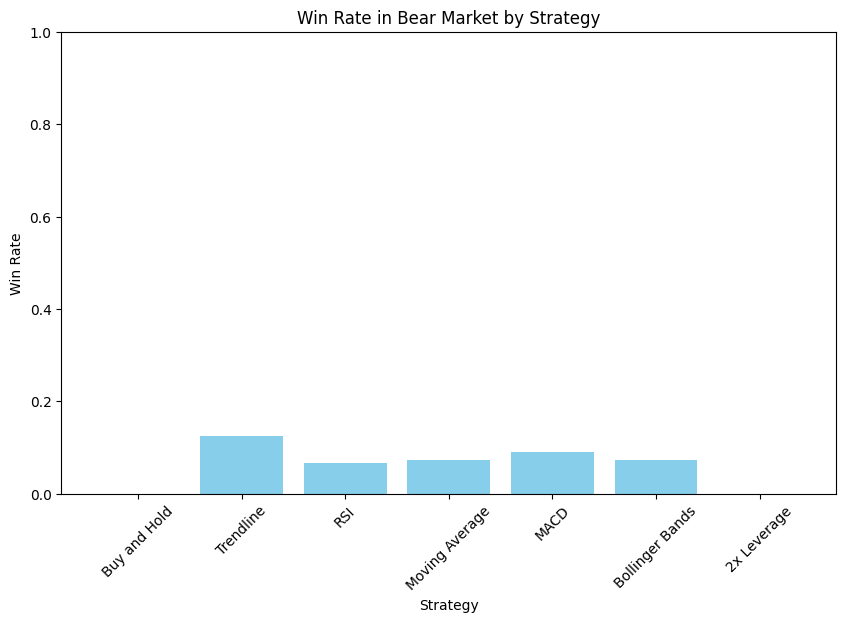

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 하락장을 정의하는 함수 (End BTC Price가 Start BTC Price보다 낮은 경우)
def is_bear_market(row):
    return row['End BTC Price'] < row['Start BTC Price']

# 각 전략의 하락장 승률을 계산하는 함수
def calculate_bear_market_win_rate(results_df):
    bear_market_mask = results_df.apply(is_bear_market, axis=1)
    win_rates = {}

    for strategy in ['Buy and Hold', 'Trendline', 'RSI', 'Moving Average', 'MACD', 'Bollinger Bands', '2x Leverage']:
        wins = (results_df[strategy] > 10000) & bear_market_mask
        win_rate = wins.mean()
        win_rates[strategy] = win_rate

    return win_rates

# 하락장 승률 계산
bear_market_win_rates = calculate_bear_market_win_rate(results_df)

# 결과 출력
for strategy, win_rate in bear_market_win_rates.items():
    print(f"{strategy} 하락장 승률: {win_rate:.2%}")

# 하락장 승률 시각화
strategies = list(bear_market_win_rates.keys())
win_rates = list(bear_market_win_rates.values())

plt.figure(figsize=(10, 6))
plt.bar(strategies, win_rates, color='skyblue')
plt.xlabel('Strategy')
plt.ylabel('Win Rate')
plt.title('Win Rate in Bear Market by Strategy')
plt.ylim(0, 1)  # 승률은 0에서 1 사이의 값이므로 y축 범위를 설정합니다.
plt.xticks(rotation=45)
plt.show()

[*********************100%%**********************]  5 of 5 completed
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\2232178958.py:44: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatilities = data.pct_change().rolling(window=252).std() * np.sqrt(252)
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\2232178958.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataF

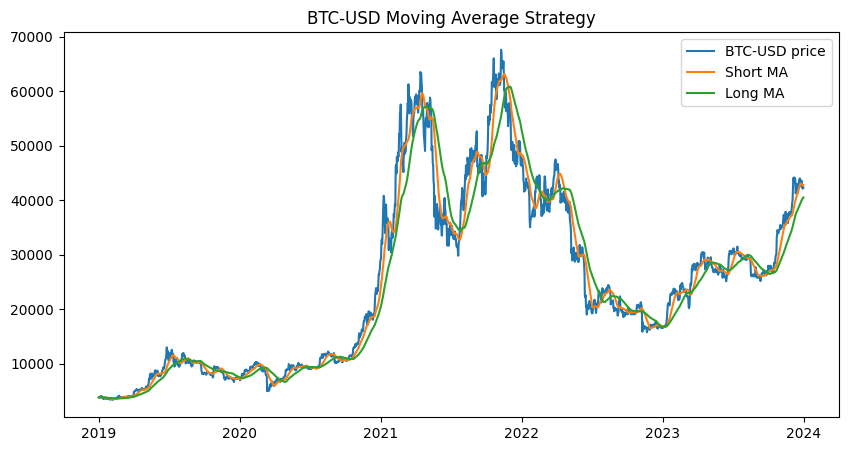

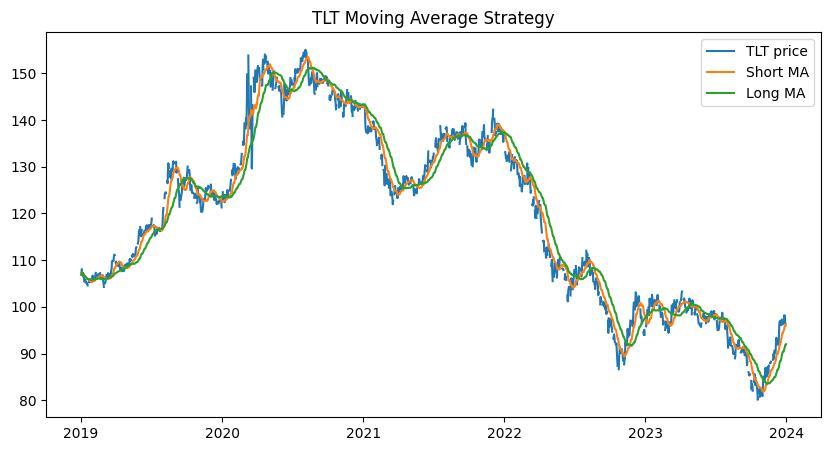

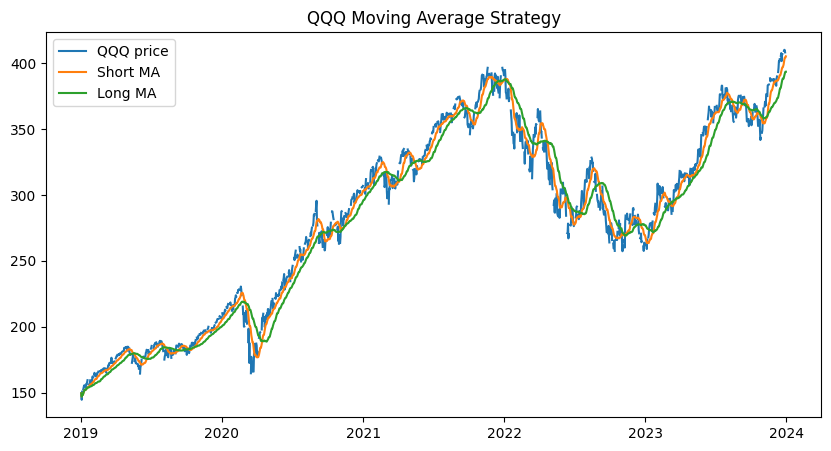

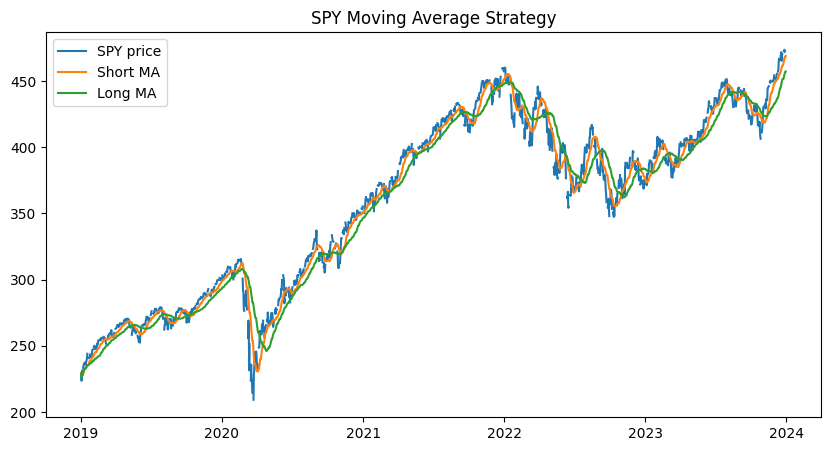

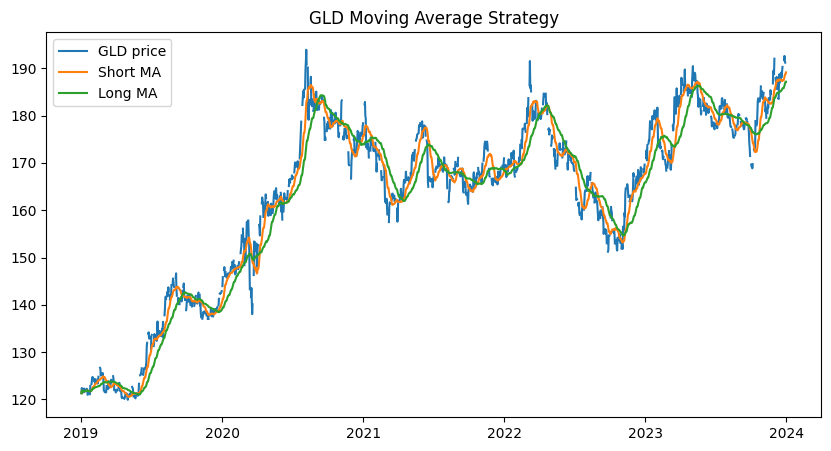

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
data = yf.download(assets, start="2019-01-01", end="2024-01-01")['Adj Close']

# 기술적 분석 전략 정의
def moving_average(data, short_window=20, long_window=50):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = data.rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data.rolling(window=long_window, min_periods=1).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()
    return signals

def macd(data):
    exp1 = data.ewm(span=12, adjust=False).mean()
    exp2 = data.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd - signal

def rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window).mean()
    rolling_std = data.rolling(window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# 동적 자산 배분과 리스크 관리 전략
def apply_dynamic_allocation(data, initial_allocations):
    # 예: 변동성에 따른 자산 재배분 로직
    volatilities = data.pct_change().rolling(window=252).std() * np.sqrt(252)
    low_vol_assets = volatilities.mean().nsmallest(2).index
    high_vol_assets = volatilities.mean().nlargest(3).index
    new_allocations = {asset: 0.1 for asset in data.columns}
    for asset in low_vol_assets:
        new_allocations[asset] += 0.15
    for asset in high_vol_assets:
        new_allocations[asset] += 0.2
    return new_allocations

# 헷지 전략 실행
def apply_hedging_strategy(data, allocations):
    # 예: 옵션 헷징 로직 추가 가능
    return allocations

# 포트폴리오 실행 및 평가
initial_allocations = {asset: 1/len(assets) for asset in assets}
dynamic_allocations = apply_dynamic_allocation(data, initial_allocations)
hedged_allocations = apply_hedging_strategy(data, dynamic_allocations)

# 전략 실행 및 결과 비교
def execute_strategies(data):
    # 각 자산에 대한 전략 실행
    strategies_output = {}
    for asset in assets:
        ma_signals = moving_average(data[asset])
        macd_values = macd(data[asset])
        rsi_values = rsi(data[asset])
        upper_band, lower_band = bollinger_bands(data[asset])
        strategies_output[asset] = (ma_signals, macd_values, rsi_values, upper_band, lower_band)
    return strategies_output

# 전략 실행
strategies_output = execute_strategies(data)

# 결과 시각화
for asset in assets:
    plt.figure(figsize=(10, 5))
    plt.plot(data[asset], label=f'{asset} price')
    plt.plot(strategies_output[asset][0]['short_mavg'], label='Short MA')
    plt.plot(strategies_output[asset][0]['long_mavg'], label='Long MA')
    plt.title(f'{asset} Moving Average Strategy')
    plt.legend()
    plt.show()

# 마지막으로 결과 평가 및 출력
def evaluate_results(strategy_outputs):
    # 결과 분석 로직
    pass

evaluate_results(strategies_output)


[*********************100%%**********************]  5 of 5 completed
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\2232178958.py:44: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatilities = data.pct_change().rolling(window=252).std() * np.sqrt(252)
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\2232178958.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataF

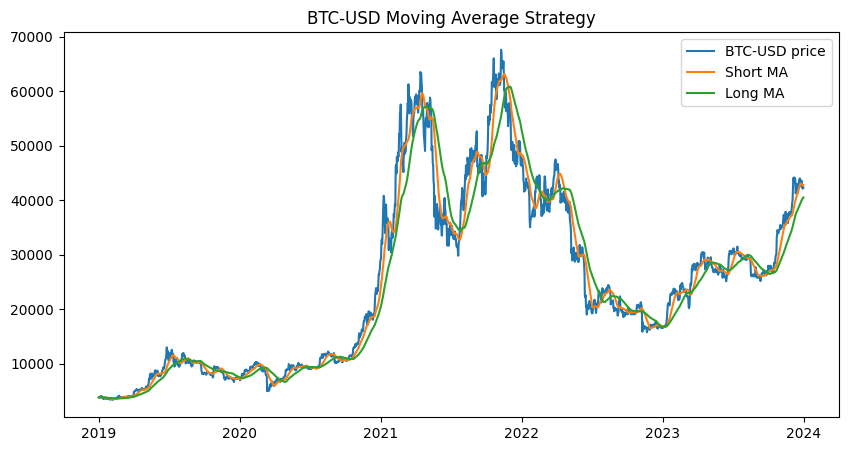

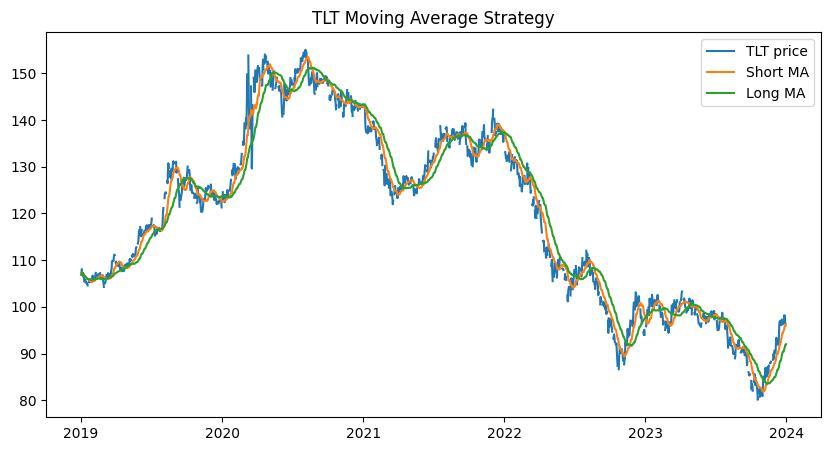

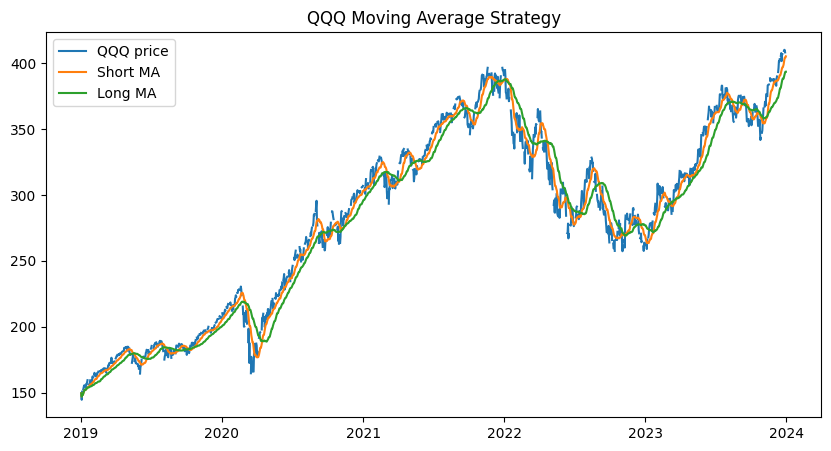

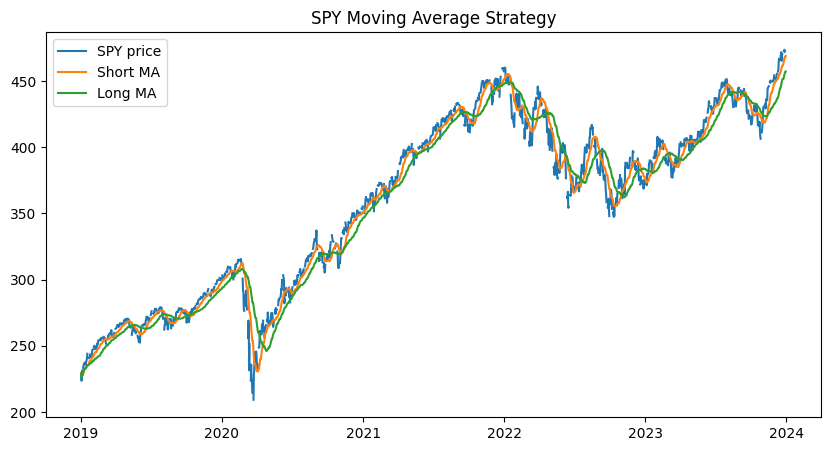

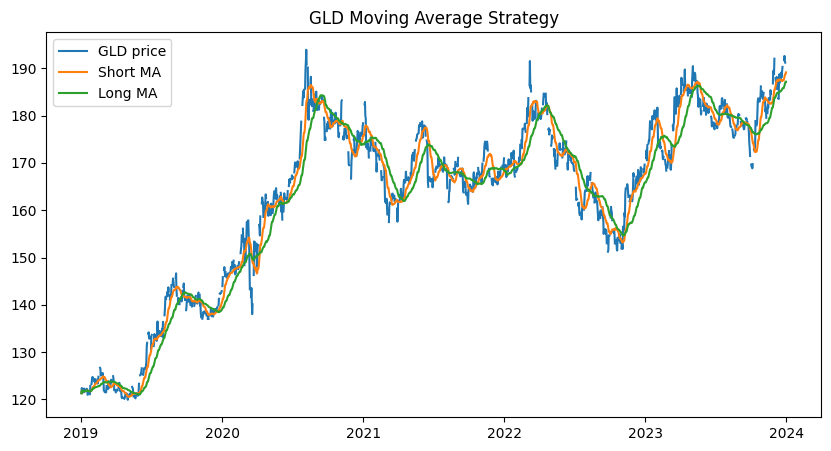

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
data = yf.download(assets, start="2019-01-01", end="2024-01-01")['Adj Close']

# 기술적 분석 전략 정의
def moving_average(data, short_window=20, long_window=50):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = data.rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data.rolling(window=long_window, min_periods=1).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff()
    return signals

def macd(data):
    exp1 = data.ewm(span=12, adjust=False).mean()
    exp2 = data.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd - signal

def rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window).mean()
    rolling_std = data.rolling(window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# 동적 자산 배분과 리스크 관리 전략
def apply_dynamic_allocation(data, initial_allocations):
    # 예: 변동성에 따른 자산 재배분 로직
    volatilities = data.pct_change().rolling(window=252).std() * np.sqrt(252)
    low_vol_assets = volatilities.mean().nsmallest(2).index
    high_vol_assets = volatilities.mean().nlargest(3).index
    new_allocations = {asset: 0.1 for asset in data.columns}
    for asset in low_vol_assets:
        new_allocations[asset] += 0.15
    for asset in high_vol_assets:
        new_allocations[asset] += 0.2
    return new_allocations

# 헷지 전략 실행
def apply_hedging_strategy(data, allocations):
    # 예: 옵션 헷징 로직 추가 가능
    return allocations

# 포트폴리오 실행 및 평가
initial_allocations = {asset: 1/len(assets) for asset in assets}
dynamic_allocations = apply_dynamic_allocation(data, initial_allocations)
hedged_allocations = apply_hedging_strategy(data, dynamic_allocations)

# 전략 실행 및 결과 비교
def execute_strategies(data):
    # 각 자산에 대한 전략 실행
    strategies_output = {}
    for asset in assets:
        ma_signals = moving_average(data[asset])
        macd_values = macd(data[asset])
        rsi_values = rsi(data[asset])
        upper_band, lower_band = bollinger_bands(data[asset])
        strategies_output[asset] = (ma_signals, macd_values, rsi_values, upper_band, lower_band)
    return strategies_output

# 전략 실행
strategies_output = execute_strategies(data)

# 결과 시각화
for asset in assets:
    plt.figure(figsize=(10, 5))
    plt.plot(data[asset], label=f'{asset} price')
    plt.plot(strategies_output[asset][0]['short_mavg'], label='Short MA')
    plt.plot(strategies_output[asset][0]['long_mavg'], label='Long MA')
    plt.title(f'{asset} Moving Average Strategy')
    plt.legend()
    plt.show()

# 마지막으로 결과 평가 및 출력
def evaluate_results(strategy_outputs):
    # 결과 분석 로직
    pass

evaluate_results(strategies_output)


In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
data = yf.download(assets, start="2019-01-01", end="2024-01-01")['Adj Close']

# 기술적 분석 전략 정의
def moving_average(data, short_window=20, long_window=50):
    signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        signals[f'{asset}_signal'] = 0.0
        signals[f'{asset}_short_mavg'] = data[asset].rolling(window=short_window, min_periods=1).mean()
        signals[f'{asset}_long_mavg'] = data[asset].rolling(window=long_window, min_periods=1).mean()
        signals[f'{asset}_signal'][short_window:] = np.where(signals[f'{asset}_short_mavg'][short_window:] > signals[f'{asset}_long_mavg'][short_window:], 1.0, 0.0)
        signals[f'{asset}_positions'] = signals[f'{asset}_signal'].diff()
    return signals

def macd(data):
    macd_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        exp1 = data[asset].ewm(span=12, adjust=False).mean()
        exp2 = data[asset].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        macd_signals[asset] = macd - signal
    return macd_signals

def rsi(data, periods=14):
    rsi_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        delta = data[asset].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi_signals[asset] = 100 - (100 / (1 + rs))
    return rsi_signals

def bollinger_bands(data, window=20, num_std=2):
    bollinger_signals = {}
    for asset in data.columns:
        rolling_mean = data[asset].rolling(window).mean()
        rolling_std = data[asset].rolling(window).std()
        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)
        bollinger_signals[asset] = (upper_band, lower_band)
    return bollinger_signals

# 전략 실행 및 결과 비교
def execute_strategy(data, strategy):
    if strategy == 'moving_average':
        return moving_average(data)
    elif strategy == 'macd':
        return macd(data)
    elif strategy == 'rsi':
        return rsi(data)
    elif strategy == 'bollinger_bands':
        return bollinger_bands(data)
    else:
        raise ValueError("Unknown strategy")

# 랜덤 기간 생성
def generate_random_periods(start_date, end_date, num_periods=5000):
    periods = []
    date_range = pd.date_range(start=start_date, end=end_date)
    for _ in range(num_periods):
        start = random.choice(date_range)
        end = random.choice(date_range)
        if start < end:
            periods.append((start, end))
    return periods

# 전략 평가
def evaluate_strategy(data, strategy, start_date, end_date):
    subset = data.loc[start_date:end_date]
    if subset.empty:
        return None
    result = execute_strategy(subset, strategy)
    if strategy == 'moving_average':
        return result.filter(like='_positions').sum().sum()
    elif strategy == 'macd':
        return result.sum().sum()
    elif strategy == 'rsi':
        return result.mean().mean()
    elif strategy == 'bollinger_bands':
        return sum((result[asset][0] - result[asset][1]).mean() for asset in result)
    else:
        return None

# 최적의 전략 찾기

[*********************100%%**********************]  5 of 5 completed


[*********************100%%**********************]  5 of 5 completed


최적의 전략: (Timestamp('2019-06-20 00:00:00'), Timestamp('2021-02-23 00:00:00'), 'macd', 18085.904530066233)


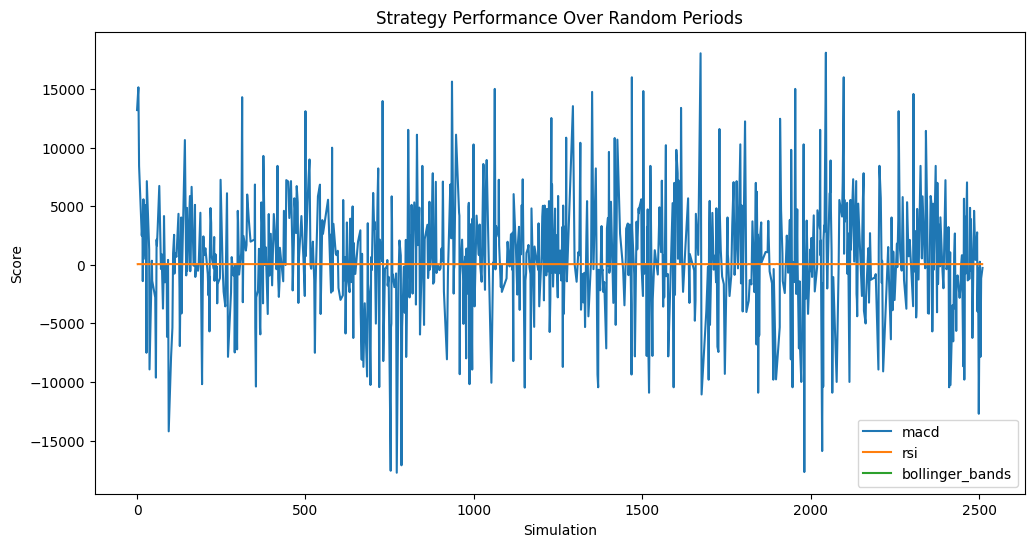

In [28]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
data = yf.download(assets, start="2019-01-01", end="2024-01-01")['Adj Close']

# 기술적 분석 전략 정의
def macd(data):
    macd_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        exp1 = data[asset].ewm(span=12, adjust=False).mean()
        exp2 = data[asset].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        macd_signals[asset] = macd - signal
    return macd_signals

def rsi(data, periods=14):
    rsi_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        delta = data[asset].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi_signals[asset] = 100 - (100 / (1 + rs))
    return rsi_signals

def bollinger_bands(data, window=20, num_std=2):
    bollinger_signals = {}
    for asset in data.columns:
        rolling_mean = data[asset].rolling(window).mean()
        rolling_std = data[asset].rolling(window).std()
        upper_band = rolling_mean + (rolling_std * num_std)
        lower_band = rolling_mean - (rolling_std * num_std)
        bollinger_signals[asset] = (upper_band, lower_band)
    return bollinger_signals

# 전략 실행 및 결과 비교
def execute_strategy(data, strategy):
    if strategy == 'macd':
        return macd(data)
    elif strategy == 'rsi':
        return rsi(data)
    elif strategy == 'bollinger_bands':
        return bollinger_bands(data)
    else:
        raise ValueError("Unknown strategy")

# 랜덤 기간 생성
def generate_random_periods(start_date, end_date, num_periods=5000):
    periods = []
    date_range = pd.date_range(start=start_date, end=end_date)
    for _ in range(num_periods):
        start = random.choice(date_range)
        end = random.choice(date_range)
        if start < end:
            periods.append((start, end))
    return periods

# 전략 평가
def evaluate_strategy(data, strategy, start_date, end_date):
    subset = data.loc[start_date:end_date]
    if subset.empty:
        return None
    result = execute_strategy(subset, strategy)
    if strategy == 'macd':
        return result.sum().sum()
    elif strategy == 'rsi':
        return result.mean().mean()
    elif strategy == 'bollinger_bands':
        return sum((result[asset][0] - result[asset][1]).mean() for asset in result)
    else:
        return None

# 최적의 전략 찾기
def find_best_strategy(data, periods, strategies):
    best_strategy = None
    best_score = -np.inf
    results = []

    for start_date, end_date in periods:
        strategy = random.choice(strategies)
        score = evaluate_strategy(data, strategy, start_date, end_date)
        if score is not None:
            score = score.item() if isinstance(score, np.generic) else score
            results.append((start_date, end_date, strategy, score))
            if score > best_score:
                best_score = score
                best_strategy = (start_date, end_date, strategy, score)

    return best_strategy, results

# 랜덤 기간 생성
random_periods = generate_random_periods("2019-01-01", "2024-01-01")

# 전략 목록
strategies = ['macd', 'rsi', 'bollinger_bands']

# 최적의 전략 찾기
best_strategy, results = find_best_strategy(data, random_periods, strategies)

# 결과 출력
print(f"최적의 전략: {best_strategy}")

# 결과 시각화
results_df = pd.DataFrame(results, columns=['Start Date', 'End Date', 'Strategy', 'Score'])
plt.figure(figsize=(12, 6))
for strategy in strategies:
    subset = results_df[results_df['Strategy'] == strategy]
    plt.plot(subset['Score'], label=strategy)
plt.xlabel('Simulation')
plt.ylabel('Score')
plt.title('Strategy Performance Over Random Periods')
plt.legend()
plt.show()

[*********************100%%**********************]  5 of 5 completed
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\4173795101.py:55: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  hedge_signals = data.pct_change().apply(lambda x: -x if x.name == hedge_asset else x)
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\4173795101.py:111: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\4173795101.py:96: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in

최적의 전략: (Timestamp('2021-07-20 00:00:00'), Timestamp('2021-08-09 00:00:00'), 'macd', 6.981737205653651)


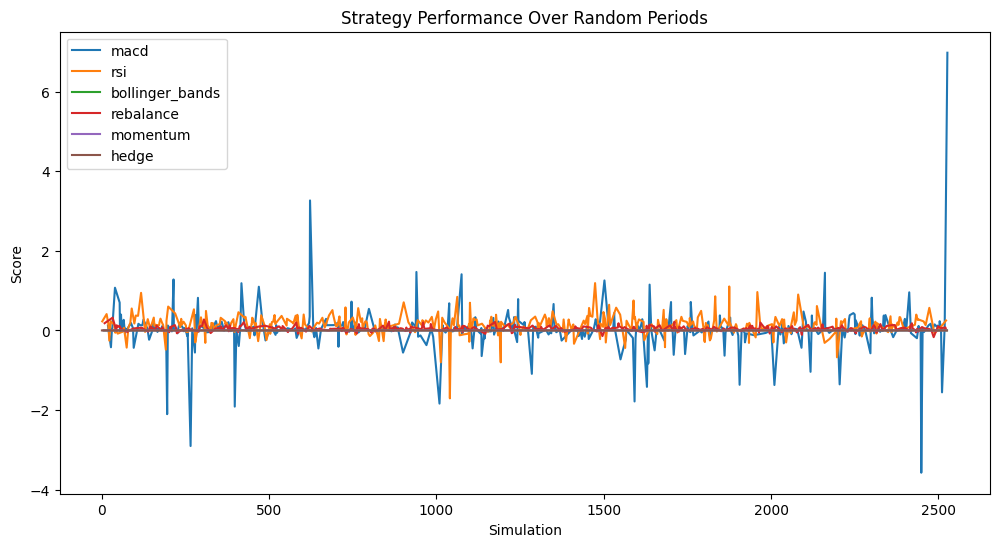

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
data = yf.download(assets, start="2019-01-01", end="2024-01-01")['Adj Close']

# 기술적 분석 전략 정의
def macd(data):
    macd_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        exp1 = data[asset].ewm(span=12, adjust=False).mean()
        exp2 = data[asset].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        macd_signals[asset] = macd - signal
    return macd_signals

def rsi(data, periods=14):
    rsi_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        delta = data[asset].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi_signals[asset] = 100 - (100 / (1 + rs))
    return rsi_signals

def bollinger_bands(data, window=20, num_std=2):
    upper_band = pd.DataFrame(index=data.index)
    lower_band = pd.DataFrame(index=data.index)
    for asset in data.columns:
        rolling_mean = data[asset].rolling(window).mean()
        rolling_std = data[asset].rolling(window).std()
        upper_band[asset] = rolling_mean + (rolling_std * num_std)
        lower_band[asset] = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# 포트폴리오 리밸런싱 전략
def rebalance_portfolio(data, weights, rebalance_period='M'):
    portfolio = (data * weights).sum(axis=1)
    rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
    return rebalanced_portfolio

# 모멘텀 전략
def momentum_strategy(data, lookback_period=12):
    momentum_signals = data.pct_change(lookback_period).shift(1)
    return momentum_signals

# 헷지 전략
def hedge_strategy(data, hedge_asset='TLT'):
    hedge_signals = data.pct_change().apply(lambda x: -x if x.name == hedge_asset else x)
    return hedge_signals

# 전략 실행 및 결과 비교
def execute_strategy(data, strategy, **kwargs):
    if strategy == 'macd':
        return macd(data)
    elif strategy == 'rsi':
        return rsi(data)
    elif strategy == 'bollinger_bands':
        return bollinger_bands(data)
    elif strategy == 'rebalance':
        return rebalance_portfolio(data, kwargs['weights'], kwargs.get('rebalance_period', 'M'))
    elif strategy == 'momentum':
        return momentum_strategy(data, kwargs.get('lookback_period', 12))
    elif strategy == 'hedge':
        return hedge_strategy(data, kwargs.get('hedge_asset', 'TLT'))
    else:
        raise ValueError("Unknown strategy")

# 랜덤 기간 생성
def generate_random_periods(start_date, end_date, num_periods=5000):
    periods = []
    date_range = pd.date_range(start=start_date, end=end_date)
    for _ in range(num_periods):
        start = random.choice(date_range)
        end = random.choice(date_range)
        if start < end:
            periods.append((start, end))
    return periods

# 전략 평가
def evaluate_strategy(data, strategy, start_date, end_date, **kwargs):
    subset = data.loc[start_date:end_date]
    if subset.empty:
        return None
    result = execute_strategy(subset, strategy, **kwargs)
    
    # 각 전략의 결과를 평가하는 방식 개선
    if strategy in ['macd', 'rsi', 'momentum']:
        # 수익률 계산
        returns = subset.pct_change().dropna()
        signals = result.shift(1).dropna()
        strategy_returns = (signals * returns).mean().sum()
        return strategy_returns
    elif strategy == 'bollinger_bands':
        upper_band, lower_band = result
        position = pd.DataFrame(index=subset.index)
        for asset in subset.columns:
            position[asset] = np.where(subset[asset] > upper_band[asset], -1, np.where(subset[asset] < lower_band[asset], 1, 0))
        returns = subset.pct_change().dropna()
        strategy_returns = (position.shift(1) * returns).mean().sum()
        return strategy_returns
    elif strategy == 'rebalance':
        return result.mean()
    elif strategy == 'hedge':
        returns = subset.pct_change().dropna()
        strategy_returns = (result.shift(1) * returns).mean().sum()
        return strategy_returns
    else:
        return None

# 최적의 전략 찾기
def find_best_strategy(data, periods, strategies, **kwargs):
    best_strategy = None
    best_score = -np.inf
    results = []

    for start_date, end_date in periods:
        strategy = random.choice(strategies)
        score = evaluate_strategy(data, strategy, start_date, end_date, **kwargs)
        if score is not None:
            score = score.item() if isinstance(score, np.generic) else score
            results.append((start_date, end_date, strategy, score))
            if score > best_score:
                best_score = score
                best_strategy = (start_date, end_date, strategy, score)

    return best_strategy, results

# 랜덤 기간 생성
random_periods = generate_random_periods("2019-01-01", "2024-01-01")

# 전략 목록
strategies = ['macd', 'rsi', 'bollinger_bands', 'rebalance', 'momentum', 'hedge']

# 최적의 전략 찾기
best_strategy, results = find_best_strategy(data, random_periods, strategies, weights=[0.2, 0.2, 0.2, 0.2, 0.2], lookback_period=12, hedge_asset='TLT')

# 결과 출력
print(f"최적의 전략: {best_strategy}")

# 결과 시각화
results_df = pd.DataFrame(results, columns=['Start Date', 'End Date', 'Strategy', 'Score'])
plt.figure(figsize=(12, 6))
for strategy in strategies:
    subset = results_df[results_df['Strategy'] == strategy]
    plt.plot(subset['Score'], label=strategy)
plt.xlabel('Simulation')
plt.ylabel('Score')
plt.title('Strategy Performance Over Random Periods')
plt.legend()
plt.show()

[*********************100%%**********************]  5 of 5 completed
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\3412343526.py:96: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\3412343526.py:96: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_32188\3412343526.py:96: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leadin

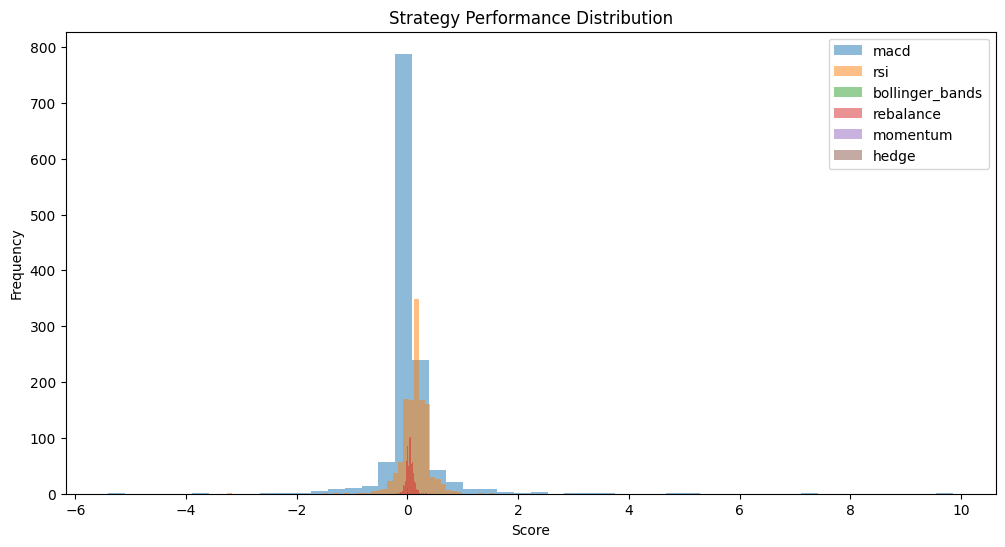

macd 평균 스코어: 0.067092233038621
rsi 평균 스코어: 0.14374812640964585
bollinger_bands 평균 스코어: -0.00025058963616028743
rebalance 평균 스코어: 0.04525483899323748
momentum 평균 스코어: 0.00022427594281726815
hedge 평균 스코어: -0.00010249299071695682


In [34]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
data = yf.download(assets, start="2019-01-01", end="2024-01-01")['Adj Close']

# 기술적 분석 전략 정의
def macd(data):
    macd_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        exp1 = data[asset].ewm(span=12, adjust=False).mean()
        exp2 = data[asset].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        macd_signals[asset] = macd - signal
    return macd_signals

def rsi(data, periods=14):
    rsi_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        delta = data[asset].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi_signals[asset] = 100 - (100 / (1 + rs))
    return rsi_signals

def bollinger_bands(data, window=20, num_std=2):
    upper_band = pd.DataFrame(index=data.index)
    lower_band = pd.DataFrame(index=data.index)
    for asset in data.columns:
        rolling_mean = data[asset].rolling(window).mean()
        rolling_std = data[asset].rolling(window).std()
        upper_band[asset] = rolling_mean + (rolling_std * num_std)
        lower_band[asset] = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# 포트폴리오 리밸런싱 전략
def rebalance_portfolio(data, weights, rebalance_period='M'):
    portfolio = (data * weights).sum(axis=1)
    rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
    return rebalanced_portfolio

# 모멘텀 전략
def momentum_strategy(data, lookback_period=12):
    momentum_signals = data.pct_change(lookback_period).shift(1)
    return momentum_signals

# 헷지 전략
def hedge_strategy(data, hedge_asset='TLT'):
    hedge_signals = data.pct_change().apply(lambda x: -x if x.name == hedge_asset else x)
    return hedge_signals

# 전략 실행 및 결과 비교
def execute_strategy(data, strategy, **kwargs):
    if strategy == 'macd':
        return macd(data)
    elif strategy == 'rsi':
        return rsi(data)
    elif strategy == 'bollinger_bands':
        return bollinger_bands(data)
    elif strategy == 'rebalance':
        return rebalance_portfolio(data, kwargs['weights'], kwargs.get('rebalance_period', 'M'))
    elif strategy == 'momentum':
        return momentum_strategy(data, kwargs.get('lookback_period', 12))
    elif strategy == 'hedge':
        return hedge_strategy(data, kwargs.get('hedge_asset', 'TLT'))
    else:
        raise ValueError("Unknown strategy")

# 랜덤 기간 생성
def generate_random_periods(start_date, end_date, num_periods=5000):
    periods = []
    date_range = pd.date_range(start=start_date, end=end_date)
    for _ in range(num_periods):
        start = random.choice(date_range)
        end = random.choice(date_range)
        if start < end:
            periods.append((start, end))
    return periods

# 전략 평가
def evaluate_strategy(data, strategy, start_date, end_date, **kwargs):
    subset = data.loc[start_date:end_date]
    if subset.empty:
        return None
    result = execute_strategy(subset, strategy, **kwargs)
    
    # 각 전략의 결과를 평가하는 방식 개선
    if strategy in ['macd', 'rsi', 'momentum']:
        # 수익률 계산
        returns = subset.pct_change().dropna()
        signals = result.shift(1).dropna()
        strategy_returns = (signals * returns).mean().sum()
        return strategy_returns
    elif strategy == 'bollinger_bands':
        upper_band, lower_band = result
        position = pd.DataFrame(index=subset.index)
        for asset in subset.columns:
            position[asset] = np.where(subset[asset] > upper_band[asset], -1, np.where(subset[asset] < lower_band[asset], 1, 0))
        returns = subset.pct_change().dropna()
        strategy_returns = (position.shift(1) * returns).mean().sum()
        return strategy_returns
    elif strategy == 'rebalance':
        # 포트폴리오 수익률 계산
        portfolio_returns = result
        strategy_returns = portfolio_returns.mean()
        return strategy_returns
    elif strategy == 'hedge':
        returns = subset.pct_change().dropna()
        strategy_returns = (result.shift(1) * returns).mean().sum()
        return strategy_returns
    else:
        return None

# 최적의 전략 찾기
def find_best_strategy(data, periods, strategies, **kwargs):
    best_strategy = None
    best_score = -np.inf
    results = []

    for start_date, end_date in periods:
        strategy = random.choice(strategies)
        score = evaluate_strategy(data, strategy, start_date, end_date, **kwargs)
        if score is not None:
            score = score.item() if isinstance(score, np.generic) else score
            results.append((start_date, end_date, strategy, score))
            if score > best_score:
                best_score = score
                best_strategy = (start_date, end_date, strategy, score)

    return best_strategy, results

# 모든 전략을 각각 2500번씩 실행
def evaluate_all_strategies(data, strategies, num_iterations=2500, **kwargs):
    all_results = {strategy: [] for strategy in strategies}
    for strategy in strategies:
        random_periods = generate_random_periods("2019-01-01", "2024-01-01", num_iterations)
        for start_date, end_date in random_periods:
            score = evaluate_strategy(data, strategy, start_date, end_date, **kwargs)
            if score is not None:
                score = score.item() if isinstance(score, np.generic) else score
                all_results[strategy].append(score)
    return all_results

# 전략 목록
strategies = ['macd', 'rsi', 'bollinger_bands', 'rebalance', 'momentum', 'hedge']

# 모든 전략 평가
all_results = evaluate_all_strategies(data, strategies, num_iterations=2500, weights=[0.2, 0.2, 0.2, 0.2, 0.2], lookback_period=12, hedge_asset='TLT')

# 결과 출력 및 시각화
plt.figure(figsize=(12, 6))
for strategy, scores in all_results.items():
    plt.hist(scores, bins=50, alpha=0.5, label=strategy)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Strategy Performance Distribution')
plt.legend()
plt.show()

# 각 전략의 평균 스코어 출력
for strategy, scores in all_results.items():
    print(f"{strategy} 평균 스코어: {np.mean(scores)}")

[*********************100%%**********************]  5 of 5 completed
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\4084959383.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\4084959383.py:103: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\4084959383.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\4084959

Best Rebalance Strategy: {'weights': (0.3, 0.2, 0.4, 0.2, 0.4)} with score: 0.6496434254344172
Best Momentum Strategy: {'lookback_period': 18} with score: 0.013634823551234488


C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\4084959383.py:103: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\4084959383.py:103: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\4084959383.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
C:\Users\ansck\AppData\Local\

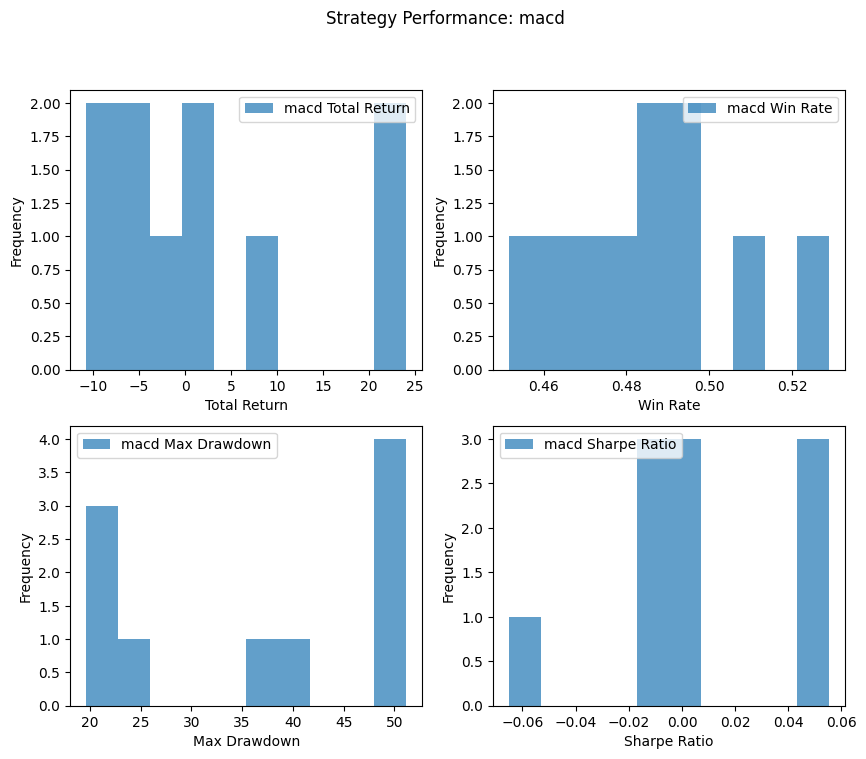

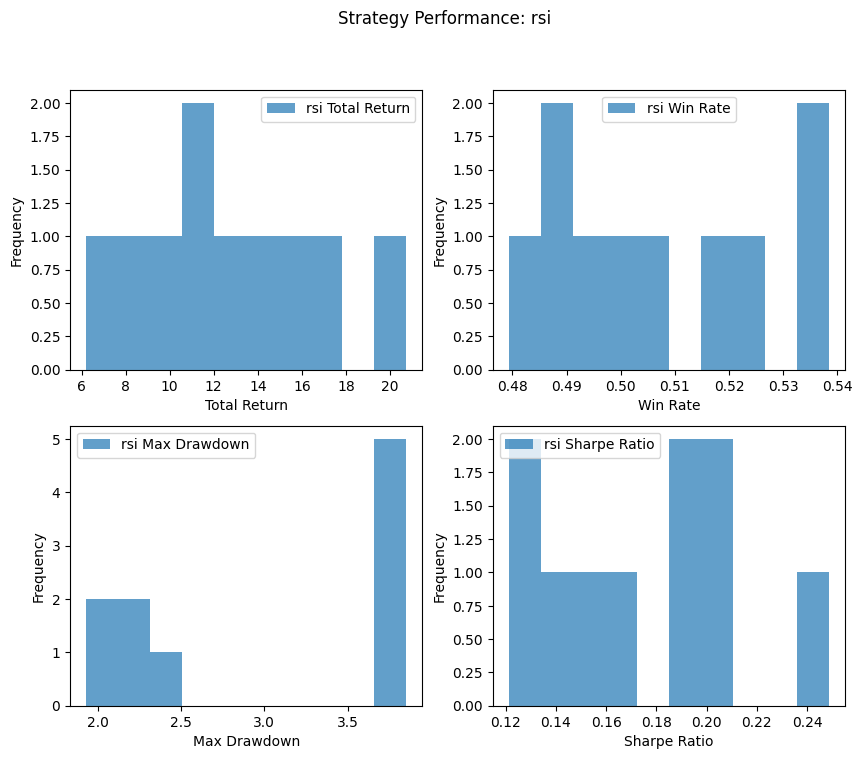

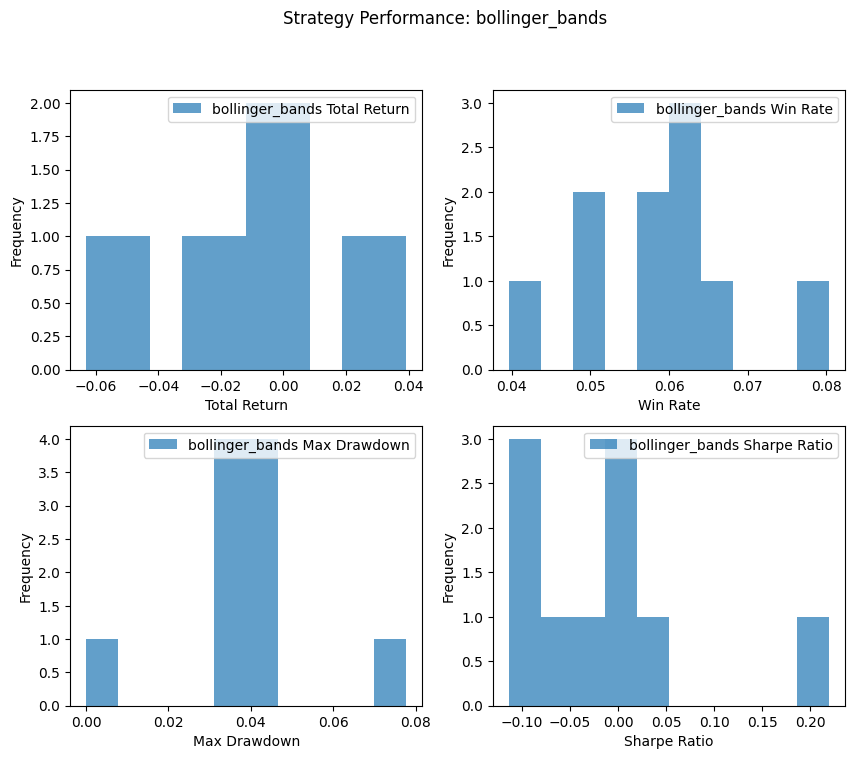

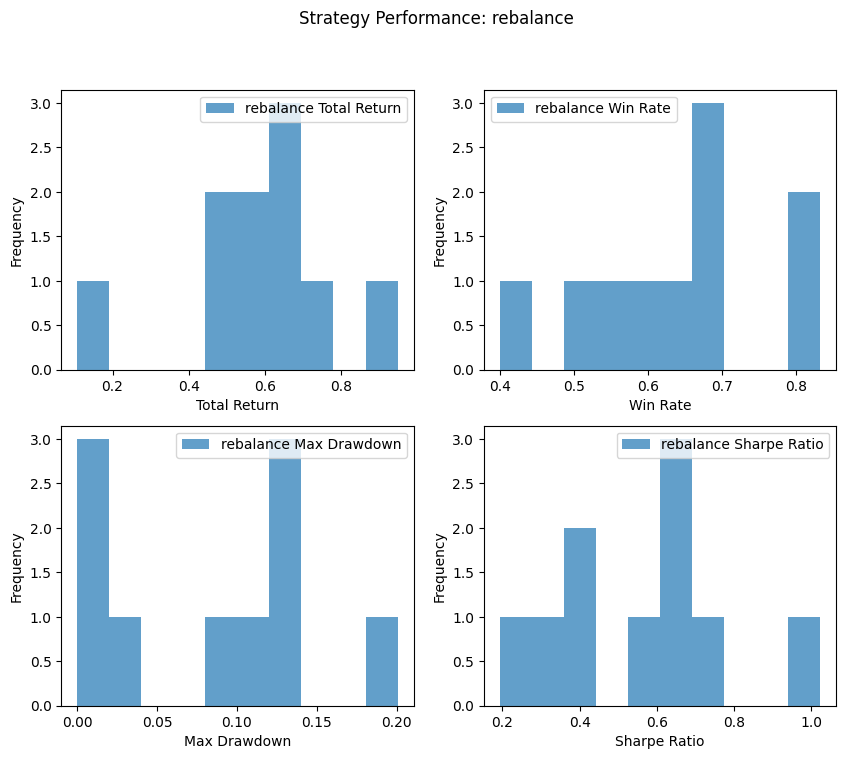

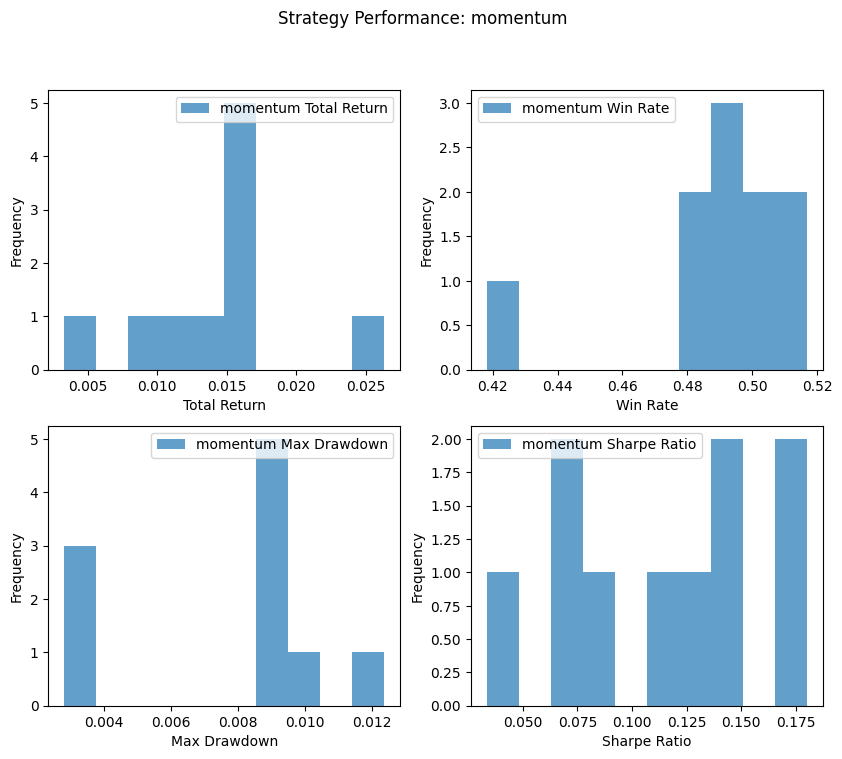

macd 평균 Total Return: 3.0816618837876204
macd 평균 Win Rate: 0.4866566110759513
macd 평균 Max Drawdown: 36.32830787452807
macd 평균 Sharpe Ratio: 0.007211591028780479
rsi 평균 Total Return: 12.661421698714667
rsi 평균 Win Rate: 0.5075385844234518
rsi 평균 Max Drawdown: 2.9540800999108603
rsi 평균 Sharpe Ratio: 0.17544783811934844
bollinger_bands 평균 Total Return: -0.010021363022515318
bollinger_bands 평균 Win Rate: 0.05885974274198054
bollinger_bands 평균 Max Drawdown: 0.040651041433484254
bollinger_bands 평균 Sharpe Ratio: -0.011793611344414144
rebalance 평균 Total Return: 0.587831904965934
rebalance 평균 Win Rate: 0.6325252525252525
rebalance 평균 Max Drawdown: 0.08379259754334227
rebalance 평균 Sharpe Ratio: 0.5579859896311896
momentum 평균 Total Return: 0.01419263737710296
momentum 평균 Win Rate: 0.4893309986129296
momentum 평균 Max Drawdown: 0.007503139721364663
momentum 평균 Sharpe Ratio: 0.1149705585044993


In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import product
from datetime import datetime, timedelta

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
end_date = datetime.today().strftime('%Y-%m-%d')  # 오늘 날짜를 end_date로 설정
data = yf.download(assets, start="2023-07-01", end=end_date)['Adj Close']

# 기술적 분석 전략 정의
def macd(data):
    macd_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        exp1 = data[asset].ewm(span=12, adjust=False).mean()
        exp2 = data[asset].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        macd_signals[asset] = macd - signal
    return macd_signals

def rsi(data, periods=14):
    rsi_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        delta = data[asset].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi_signals[asset] = 100 - (100 / (1 + rs))
    return rsi_signals

def bollinger_bands(data, window=20, num_std=2):
    upper_band = pd.DataFrame(index=data.index)
    lower_band = pd.DataFrame(index=data.index)
    for asset in data.columns:
        rolling_mean = data[asset].rolling(window).mean()
        rolling_std = data[asset].rolling(window).std()
        upper_band[asset] = rolling_mean + (rolling_std * num_std)
        lower_band[asset] = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# 포트폴리오 리밸런싱 전략
def rebalance_portfolio(data, weights, rebalance_period='M'):
    weights = np.array(weights)
    weights /= np.sum(weights)  # 가중치 정규화
    portfolio = (data * weights).sum(axis=1)
    rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
    return rebalanced_portfolio

# 모멘텀 전략
def momentum_strategy(data, lookback_period=12):
    momentum_signals = data.pct_change(lookback_period).shift(1)
    return momentum_signals

# 전략 실행 및 결과 비교
def execute_strategy(data, strategy, **kwargs):
    if strategy == 'macd':
        return macd(data)
    elif strategy == 'rsi':
        return rsi(data)
    elif strategy == 'bollinger_bands':
        return bollinger_bands(data)
    elif strategy == 'rebalance':
        return rebalance_portfolio(data, kwargs['weights'], kwargs.get('rebalance_period', 'M'))
    elif strategy == 'momentum':
        return momentum_strategy(data, kwargs.get('lookback_period', 12))
    else:
        raise ValueError("Unknown strategy")

# 랜덤 기간 생성 (1년 내의 랜덤한 시작일과 기간을 생성)
def generate_random_periods(start_date, end_date, num_periods=20):  # 랜덤 기간 수를 줄임
    periods = []
    start_date = pd.to_datetime(start_date)  # 문자열을 datetime 객체로 변환
    end_date = pd.to_datetime(end_date)      # 문자열을 datetime 객체로 변환
    for _ in range(num_periods):
        days = random.randint(30, 365)  # 1개월에서 1년 사이의 기간 선택
        start = pd.to_datetime(random.choice(pd.date_range(start=start_date, end=end_date - timedelta(days=days))))
        end = start + timedelta(days=days)
        periods.append((start, end))
    return periods

# 전략 평가
# 전략 평가
def evaluate_strategy(data, strategy, start_date, end_date, **kwargs):
    subset = data.loc[start_date:end_date]
    if subset.empty:
        return None, None, None, None
    
    result = execute_strategy(subset, strategy, **kwargs)
    
    # Bollinger Bands의 경우, 튜플로 반환되기 때문에 각각의 밴드를 개별적으로 처리
    if strategy == 'bollinger_bands':
        upper_band, lower_band = result
        if upper_band.empty or lower_band.empty:
            return None, None, None, None
    else:
        if result is None or result.empty:
            return None, None, None, None

    returns = subset.pct_change().dropna()
    
    if strategy in ['macd', 'rsi', 'momentum']:
        signals = result.shift(1).dropna()
        strategy_returns = (signals * returns).mean(axis=1)
    elif strategy == 'bollinger_bands':
        position = pd.DataFrame(index=subset.index)
        for asset in subset.columns:
            position[asset] = np.where(subset[asset] > upper_band[asset], -1, np.where(subset[asset] < lower_band[asset], 1, 0))
        strategy_returns = (position.shift(1) * returns).mean(axis=1)
    elif strategy == 'rebalance':
        strategy_returns = result
    else:
        return None, None, None, None

    total_return = strategy_returns.sum()
    win_rate = (strategy_returns > 0).mean()
    max_drawdown = (strategy_returns.cumsum().cummax() - strategy_returns.cumsum()).max()
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std()
    
    return total_return, win_rate, max_drawdown, sharpe_ratio

# 이후 코드에 대한 수정은 필요하지 않습니다.

# 최적의 하이퍼파라미터 찾기 (랜덤 서치 방식)
def find_optimal_hyperparameters(data, strategy, parameter_grid, num_samples=10):
    best_params = None
    best_score = -np.inf
    
    sampled_params = random.sample(parameter_grid, min(num_samples, len(parameter_grid)))

    for params in sampled_params:
        kwargs = {k: v for k, v in zip(params.keys(), params.values())}
        random_periods = generate_random_periods("2023-07-01", "2024-08-20", 100)  # 랜덤 기간 수를 줄임
        scores = []
        for start_date, end_date in random_periods:
            total_return, win_rate, max_drawdown, sharpe_ratio = evaluate_strategy(data, strategy, start_date, end_date, **kwargs)
            if total_return is not None:
                scores.append(total_return)
        avg_score = np.mean(scores) if scores else -np.inf
        if avg_score > best_score:
            best_score = avg_score
            best_params = kwargs

    return best_params, best_score

# 하이퍼파라미터 그리드 설정
rebalance_weights_grid = list(product([0.2, 0.3, 0.4], repeat=len(assets)))
momentum_lookback_grid = [6, 12, 18]

# 전략 목록
strategies = ['macd', 'rsi', 'bollinger_bands', 'rebalance', 'momentum']

# 최적 하이퍼파라미터 찾기
best_rebalance_params, best_rebalance_score = find_optimal_hyperparameters(
    data, 
    'rebalance', 
    [{'weights': weights} for weights in rebalance_weights_grid],
    num_samples=10  # 샘플 수를 줄임
)

best_momentum_params, best_momentum_score = find_optimal_hyperparameters(
    data, 
    'momentum', 
    [{'lookback_period': lookback} for lookback in momentum_lookback_grid],
    num_samples=3  # 샘플 수를 줄임
)

print("Best Rebalance Strategy:", best_rebalance_params, "with score:", best_rebalance_score)
print("Best Momentum Strategy:", best_momentum_params, "with score:", best_momentum_score)

# 모든 전략 평가 실행
def evaluate_all_strategies(data, strategies, num_iterations=10, **kwargs):  # 반복 횟수를 줄임
    all_results = {strategy: {'Total Return': [], 'Win Rate': [], 'Max Drawdown': [], 'Sharpe Ratio': []} for strategy in strategies}
    for _ in range(num_iterations):
        random_periods = generate_random_periods("2023-07-01", "2024-08-20", 1)
        start_date, end_date = random_periods[0]
        for strategy in strategies:
            total_return, win_rate, max_drawdown, sharpe_ratio = evaluate_strategy(data, strategy, start_date, end_date, **kwargs)
            if total_return is not None:
                all_results[strategy]['Total Return'].append(total_return)
                all_results[strategy]['Win Rate'].append(win_rate)
                all_results[strategy]['Max Drawdown'].append(max_drawdown)
                all_results[strategy]['Sharpe Ratio'].append(sharpe_ratio)
    return all_results

all_results = evaluate_all_strategies(
    data, 
    strategies, 
    num_iterations=10,  # 반복 횟수를 줄임
    weights=best_rebalance_params['weights'], 
    lookback_period=best_momentum_params['lookback_period']
)

# 시각화 함수 정의
def visualize_results(results):
    for strategy, metrics in results.items():
        plt.figure(figsize=(10, 8))
        plt.suptitle(f"Strategy Performance: {strategy}")
        
        plt.subplot(2, 2, 1)
        plt.hist(metrics['Total Return'], bins=10, alpha=0.7, label=f'{strategy} Total Return')  # bin 수를 줄임
        plt.xlabel('Total Return')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(2, 2, 2)
        plt.hist(metrics['Win Rate'], bins=10, alpha=0.7, label=f'{strategy} Win Rate')
        plt.xlabel('Win Rate')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(2, 2, 3)
        plt.hist(metrics['Max Drawdown'], bins=10, alpha=0.7, label=f'{strategy} Max Drawdown')
        plt.xlabel('Max Drawdown')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(2, 2, 4)
        plt.hist(metrics['Sharpe Ratio'], bins=10, alpha=0.7, label=f'{strategy} Sharpe Ratio')
        plt.xlabel('Sharpe Ratio')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.show()

# 시각화 결과 출력
visualize_results(all_results)

# 각 전략의 평균 스코어 출력 (종합 점수 산출)
for strategy, metrics in all_results.items():
    print(f"{strategy} 평균 Total Return: {np.mean(metrics['Total Return'])}")
    print(f"{strategy} 평균 Win Rate: {np.mean(metrics['Win Rate'])}")
    print(f"{strategy} 평균 Max Drawdown: {np.mean(metrics['Max Drawdown'])}")
    print(f"{strategy} 평균 Sharpe Ratio: {np.mean(metrics['Sharpe Ratio'])}")


[*********************100%%**********************]  5 of 5 completed
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\2296736573.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\2296736573.py:101: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\2296736573.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\2296736


Best Rebalance Strategy Hyperparameters: {'weights': (0.4, 0.3, 0.4, 0.4, 0.2)}
Best Rebalance Strategy Score: 0.5449177913024522

Best Momentum Strategy Hyperparameters: {'lookback_period': 18}
Best Momentum Strategy Score: 0.09395152249771975

Rebalance Strategy Performance by Parameters:
Params: {'weights': (0.4, 0.3, 0.4, 0.4, 0.2)}, Sharpe Ratio: 0.5449
Params: {'weights': (0.2, 0.2, 0.4, 0.2, 0.2)}, Sharpe Ratio: 0.5066
Params: {'weights': (0.2, 0.2, 0.3, 0.4, 0.4)}, Sharpe Ratio: 0.4925
Params: {'weights': (0.2, 0.4, 0.2, 0.3, 0.4)}, Sharpe Ratio: 0.5309
Params: {'weights': (0.2, 0.3, 0.2, 0.4, 0.3)}, Sharpe Ratio: 0.4741
Params: {'weights': (0.2, 0.4, 0.4, 0.4, 0.4)}, Sharpe Ratio: 0.4266
Params: {'weights': (0.3, 0.3, 0.4, 0.2, 0.3)}, Sharpe Ratio: 0.5106
Params: {'weights': (0.2, 0.4, 0.4, 0.2, 0.4)}, Sharpe Ratio: 0.3286
Params: {'weights': (0.2, 0.3, 0.2, 0.2, 0.4)}, Sharpe Ratio: 0.4377
Params: {'weights': (0.2, 0.2, 0.4, 0.3, 0.4)}, Sharpe Ratio: 0.4268


C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\2296736573.py:50: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\2296736573.py:101: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = subset.pct_change().dropna()
C:\Users\ansck\AppData\Local\Temp\ipykernel_26648\2296736573.py:55: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_signals = data.pct_change(lookback_period).shift(1)
C:\Users

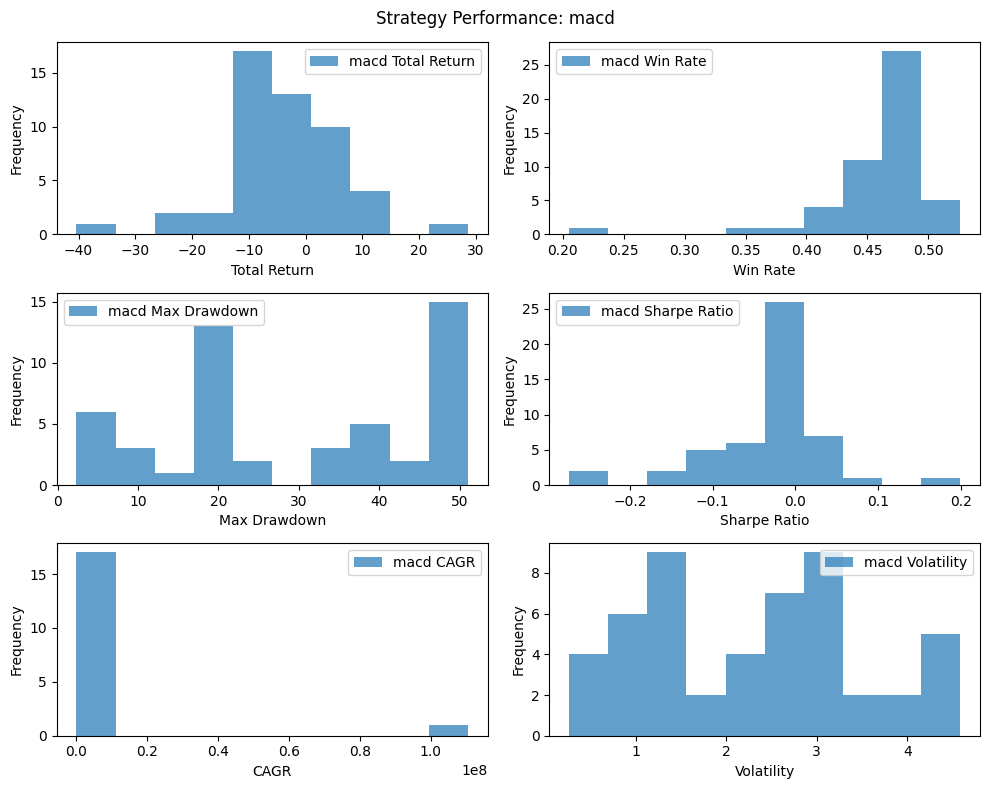

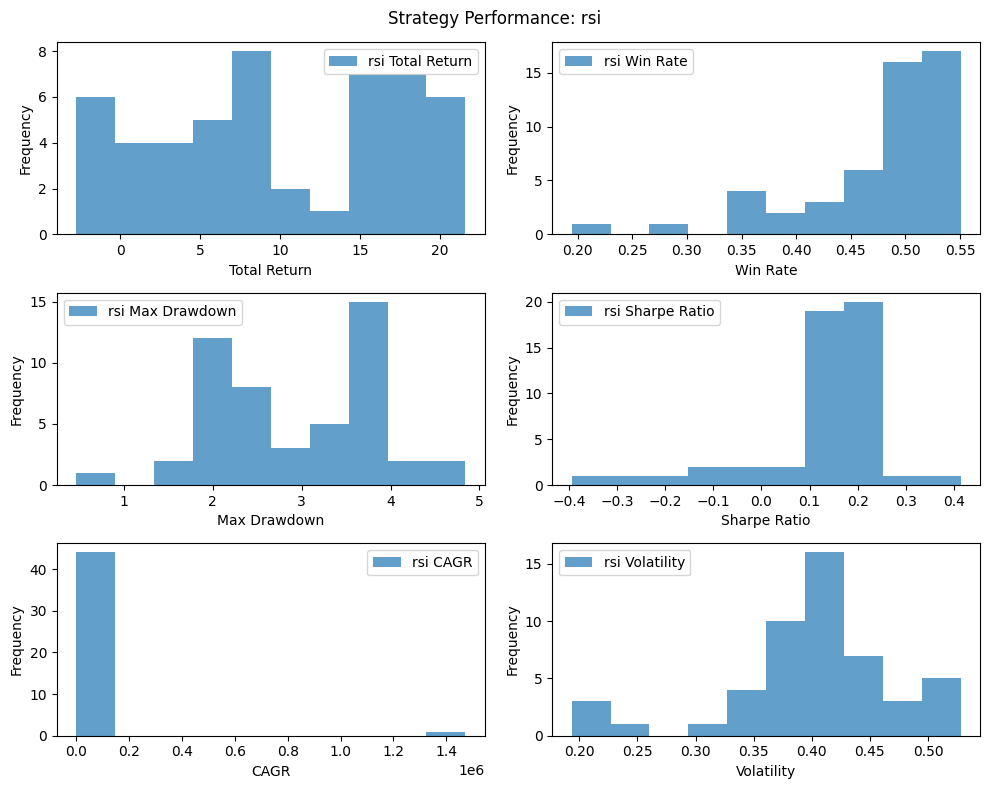

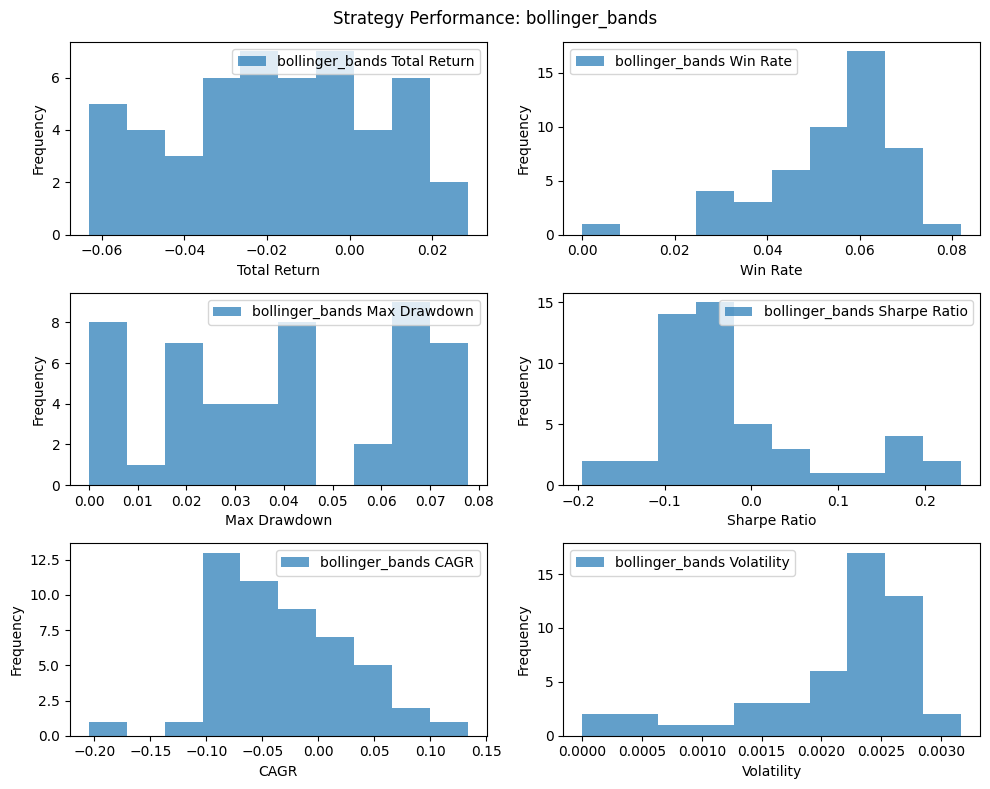

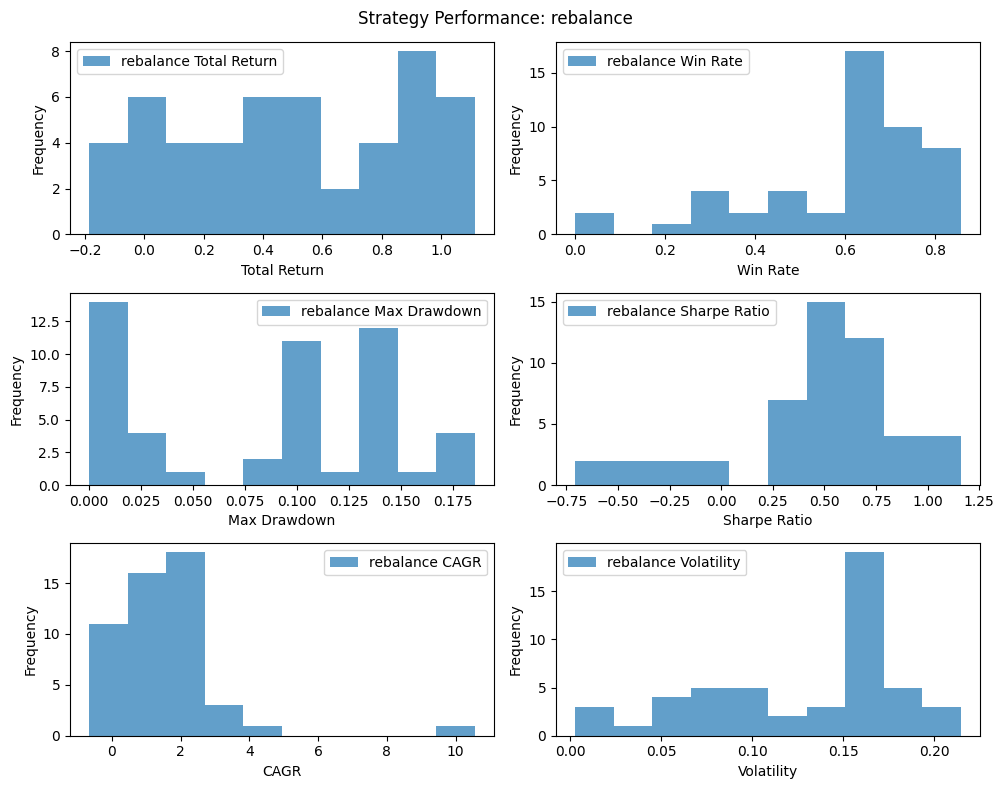

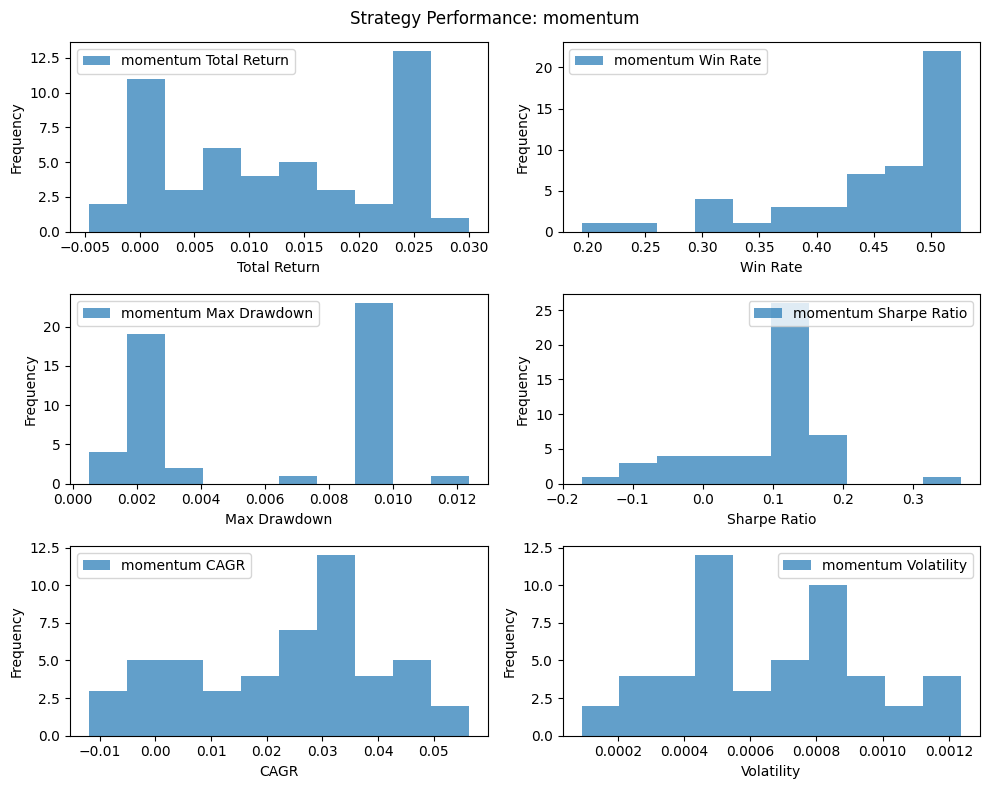


macd 전략:
평균 Total Return: -3.6510
평균 Win Rate: 0.4582
평균 Max Drawdown: 30.0431
평균 Sharpe Ratio: -0.0261
평균 CAGR: nan
평균 Volatility: 2.2912

rsi 전략:
평균 Total Return: 9.9814
평균 Win Rate: 0.4772
평균 Max Drawdown: 2.8752
평균 Sharpe Ratio: 0.1221
평균 CAGR: nan
평균 Volatility: 0.4000

bollinger_bands 전략:
평균 Total Return: -0.0182
평균 Win Rate: 0.0549
평균 Max Drawdown: 0.0399
평균 Sharpe Ratio: nan
평균 CAGR: -0.0317
평균 Volatility: 0.0021

rebalance 전략:
평균 Total Return: 0.4998
평균 Win Rate: 0.6015
평균 Max Drawdown: 0.0834
평균 Sharpe Ratio: 0.4651
평균 CAGR: 1.5319
평균 Volatility: 0.1293

momentum 전략:
평균 Total Return: 0.0122
평균 Win Rate: 0.4543
평균 Max Drawdown: 0.0056
평균 Sharpe Ratio: 0.0910
평균 CAGR: 0.0229
평균 Volatility: 0.0007

가장 추천하는 전략은 rebalance 입니다. (Sharpe Ratio 기준)


In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import product
from datetime import datetime, timedelta

# 데이터 로드
assets = ['BTC-USD', 'TLT', 'QQQ', 'SPY', 'GLD']
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(assets, start="2023-07-01", end=end_date)['Adj Close']

# 기술적 분석 전략 정의
def macd(data):
    macd_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        exp1 = data[asset].ewm(span=12, adjust=False).mean()
        exp2 = data[asset].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        macd_signals[asset] = macd - signal
    return macd_signals

def rsi(data, periods=14):
    rsi_signals = pd.DataFrame(index=data.index)
    for asset in data.columns:
        delta = data[asset].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi_signals[asset] = 100 - (100 / (1 + rs))
    return rsi_signals

def bollinger_bands(data, window=20, num_std=2):
    upper_band = pd.DataFrame(index=data.index)
    lower_band = pd.DataFrame(index=data.index)
    for asset in data.columns:
        rolling_mean = data[asset].rolling(window).mean()
        rolling_std = data[asset].rolling(window).std()
        upper_band[asset] = rolling_mean + (rolling_std * num_std)
        lower_band[asset] = rolling_mean - (rolling_std * num_std)
    return upper_band, lower_band

# 포트폴리오 리밸런싱 전략
def rebalance_portfolio(data, weights, rebalance_period='M'):
    weights = np.array(weights)
    weights /= np.sum(weights)  # 가중치 정규화
    portfolio = (data * weights).sum(axis=1)
    rebalanced_portfolio = portfolio.resample(rebalance_period).last().pct_change().fillna(0)
    return rebalanced_portfolio

# 모멘텀 전략
def momentum_strategy(data, lookback_period=12):
    momentum_signals = data.pct_change(lookback_period).shift(1)
    return momentum_signals

# 전략 실행 및 결과 비교
def execute_strategy(data, strategy, **kwargs):
    if strategy == 'macd':
        return macd(data)
    elif strategy == 'rsi':
        return rsi(data)
    elif strategy == 'bollinger_bands':
        return bollinger_bands(data)
    elif strategy == 'rebalance':
        return rebalance_portfolio(data, kwargs['weights'], kwargs.get('rebalance_period', 'M'))
    elif strategy == 'momentum':
        return momentum_strategy(data, kwargs.get('lookback_period', 12))
    else:
        raise ValueError("Unknown strategy")

# 랜덤 기간 생성 (1년 내의 랜덤한 시작일과 기간을 생성)
def generate_random_periods(start_date, end_date, num_periods=50):
    periods = []
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    for _ in range(num_periods):
        days = random.randint(30, 365)
        start = pd.to_datetime(random.choice(pd.date_range(start=start_date, end=end_date - timedelta(days=days))))
        end = start + timedelta(days=days)
        periods.append((start, end))
    return periods

# 전략 평가
def evaluate_strategy(data, strategy, start_date, end_date, **kwargs):
    subset = data.loc[start_date:end_date]
    if subset.empty:
        return None, None, None, None
    
    result = execute_strategy(subset, strategy, **kwargs)
    
    if strategy == 'bollinger_bands':
        upper_band, lower_band = result
        if upper_band.empty or lower_band.empty:
            return None, None, None, None
    else:
        if result is None or result.empty:
            return None, None, None, None

    returns = subset.pct_change().dropna()
    
    if strategy in ['macd', 'rsi', 'momentum']:
        signals = result.shift(1).dropna()
        strategy_returns = (signals * returns).mean(axis=1)
    elif strategy == 'bollinger_bands':
        position = pd.DataFrame(index=subset.index)
        for asset in subset.columns:
            position[asset] = np.where(subset[asset] > upper_band[asset], -1, np.where(subset[asset] < lower_band[asset], 1, 0))
        strategy_returns = (position.shift(1) * returns).mean(axis=1)
    elif strategy == 'rebalance':
        strategy_returns = result
    else:
        return None, None, None, None

    total_return = strategy_returns.sum()
    win_rate = (strategy_returns > 0).mean()
    max_drawdown = (strategy_returns.cumsum().cummax() - strategy_returns.cumsum()).max()
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std()
    
    # 변동성 계산
    volatility = strategy_returns.std()
    
    return total_return, win_rate, max_drawdown, sharpe_ratio, volatility

# 최적의 하이퍼파라미터 찾기 (랜덤 서치 방식)
def find_optimal_hyperparameters(data, strategy, parameter_grid, num_samples=10):
    best_params = None
    best_score = -np.inf
    performance_by_params = []
    
    sampled_params = random.sample(parameter_grid, min(num_samples, len(parameter_grid)))

    for params in sampled_params:
        kwargs = {k: v for k, v in zip(params.keys(), params.values())}
        random_periods = generate_random_periods("2023-07-01", "2024-08-20", 50)
        scores = []
        for start_date, end_date in random_periods:
            total_return, win_rate, max_drawdown, sharpe_ratio, _ = evaluate_strategy(data, strategy, start_date, end_date, **kwargs)
            if total_return is not None:
                scores.append(sharpe_ratio)
        avg_score = np.mean(scores) if scores else -np.inf
        performance_by_params.append((params, avg_score))
        if avg_score > best_score:
            best_score = avg_score
            best_params = kwargs

    return best_params, best_score, performance_by_params

# 하이퍼파라미터 그리드 설정
rebalance_weights_grid = list(product([0.2, 0.3, 0.4], repeat=len(assets)))
momentum_lookback_grid = [6, 12, 18]

# 전략 목록
strategies = ['macd', 'rsi', 'bollinger_bands', 'rebalance', 'momentum']

# 최적 하이퍼파라미터 찾기
best_rebalance_params, best_rebalance_score, rebalance_performance = find_optimal_hyperparameters(
    data, 
    'rebalance', 
    [{'weights': weights} for weights in rebalance_weights_grid],
    num_samples=10
)

best_momentum_params, best_momentum_score, _ = find_optimal_hyperparameters(
    data, 
    'momentum', 
    [{'lookback_period': lookback} for lookback in momentum_lookback_grid],
    num_samples=3
)

# 최적의 하이퍼파라미터와 그 성과 출력
print("\nBest Rebalance Strategy Hyperparameters:", best_rebalance_params)
print("Best Rebalance Strategy Score:", best_rebalance_score)

print("\nBest Momentum Strategy Hyperparameters:", best_momentum_params)
print("Best Momentum Strategy Score:", best_momentum_score)

# 리밸런싱 전략의 하이퍼파라미터 성과 출력
print("\nRebalance Strategy Performance by Parameters:")
for params, score in rebalance_performance:
    print(f"Params: {params}, Sharpe Ratio: {score:.4f}")

# 모든 전략 평가 실행
def evaluate_all_strategies(data, strategies, num_iterations=50, **kwargs):
    all_results = {strategy: {'Total Return': [], 'Win Rate': [], 'Max Drawdown': [], 'Sharpe Ratio': [], 'CAGR': [], 'Volatility': []} for strategy in strategies}
    for _ in range(num_iterations):
        random_periods = generate_random_periods("2023-07-01", "2024-08-20", 1)
        start_date, end_date = random_periods[0]
        for strategy in strategies:
            total_return, win_rate, max_drawdown, sharpe_ratio, volatility = evaluate_strategy(data, strategy, start_date, end_date, **kwargs)
            if total_return is not None:
                all_results[strategy]['Total Return'].append(total_return)
                all_results[strategy]['Win Rate'].append(win_rate)
                all_results[strategy]['Max Drawdown'].append(max_drawdown)
                all_results[strategy]['Sharpe Ratio'].append(sharpe_ratio)

                # 추가 분석 지표 계산
                duration_years = (end_date - start_date).days / 365.25
                cagr = ((1 + total_return) ** (1 / duration_years)) - 1
                
                all_results[strategy]['CAGR'].append(cagr)
                all_results[strategy]['Volatility'].append(volatility)
                
    return all_results

all_results = evaluate_all_strategies(
    data, 
    strategies, 
    num_iterations=50,
    weights=best_rebalance_params['weights'], 
    lookback_period=best_momentum_params['lookback_period']
)

# 시각화 함수 정의
def visualize_results(results):
    for strategy, metrics in results.items():
        plt.figure(figsize=(10, 8))
        plt.suptitle(f"Strategy Performance: {strategy}")
        
        plt.subplot(3, 2, 1)
        plt.hist(metrics['Total Return'], bins=10, alpha=0.7, label=f'{strategy} Total Return')
        plt.xlabel('Total Return')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(3, 2, 2)
        plt.hist(metrics['Win Rate'], bins=10, alpha=0.7, label=f'{strategy} Win Rate')
        plt.xlabel('Win Rate')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(3, 2, 3)
        plt.hist(metrics['Max Drawdown'], bins=10, alpha=0.7, label=f'{strategy} Max Drawdown')
        plt.xlabel('Max Drawdown')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.subplot(3, 2, 4)
        plt.hist(metrics['Sharpe Ratio'], bins=10, alpha=0.7, label=f'{strategy} Sharpe Ratio')
        plt.xlabel('Sharpe Ratio')
        plt.ylabel('Frequency')
        plt.legend()

        plt.subplot(3, 2, 5)
        plt.hist(metrics['CAGR'], bins=10, alpha=0.7, label=f'{strategy} CAGR')
        plt.xlabel('CAGR')
        plt.ylabel('Frequency')
        plt.legend()

        plt.subplot(3, 2, 6)
        plt.hist(metrics['Volatility'], bins=10, alpha=0.7, label=f'{strategy} Volatility')
        plt.xlabel('Volatility')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# 시각화 결과 출력
visualize_results(all_results)

# 각 전략의 평균 스코어 출력 (종합 점수 산출)
summary_results = {}
for strategy, metrics in all_results.items():
    avg_total_return = np.mean(metrics['Total Return'])
    avg_win_rate = np.mean(metrics['Win Rate'])
    avg_max_drawdown = np.mean(metrics['Max Drawdown'])
    avg_sharpe_ratio = np.mean(metrics['Sharpe Ratio'])
    avg_cagr = np.mean(metrics['CAGR'])
    avg_volatility = np.mean(metrics['Volatility'])

    summary_results[strategy] = {
        'Avg Total Return': avg_total_return,
        'Avg Win Rate': avg_win_rate,
        'Avg Max Drawdown': avg_max_drawdown,
        'Avg Sharpe Ratio': avg_sharpe_ratio,
        'Avg CAGR': avg_cagr,
        'Avg Volatility': avg_volatility,
    }

    print(f"\n{strategy} 전략:")
    print(f"평균 Total Return: {avg_total_return:.4f}")
    print(f"평균 Win Rate: {avg_win_rate:.4f}")
    print(f"평균 Max Drawdown: {avg_max_drawdown:.4f}")
    print(f"평균 Sharpe Ratio: {avg_sharpe_ratio:.4f}")
    print(f"평균 CAGR: {avg_cagr:.4f}")
    print(f"평균 Volatility: {avg_volatility:.4f}")

# 최종 추천 전략 출력
best_strategy = max(summary_results, key=lambda x: summary_results[x]['Avg Sharpe Ratio'])
print(f"\n가장 추천하는 전략은 {best_strategy} 입니다. (Sharpe Ratio 기준)")
